In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import pickle
from torcheval.metrics.functional import r2_score
from tqdm.auto import tqdm 
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from HiCMap import HiCMap
from HiCDataset import HiCDataset
from ConfigDataset import ConfigDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [6]:
resolution = 20_000
data_dir1 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
cond_scale1=1.
rescaled_phi1=0.
data_dir2 = '../data/samples/origami_64_no_embed_reduction/full_scan/corrected/'
cond_scale2=5.
rescaled_phi2=8.

imr_dir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/full_scan_IMR/corrected/'

milestone=120
save_folder = './HiCCorrelationR2_combined/'
data_fp = lambda cell_type: save_folder + f'data_{cell_type}.pkl'

# Perform computations on the GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
chroms = [*[str(k) for k in range(1,23)],'X']

The following are parameters for the distance -> contact probability conversion, i.e.
$$
p_{ij}(r_{ij}) = 
\begin{cases}
    \frac{\left[ 1 + \tanh\left( \sigma\left( r_c - r_{ij} \right) \right) \right]}{2} & r_{ij} < r_c \\
    \left( \frac{r_c}{r_{ij}} \right)^4 & \text{otherwise}
\end{cases}
$$
where $p_{ij}$ and $r_{ij}$ are the contact probability and spatial separation between monomers $i$ and $j$, respectively, $r_c$ is the cutoff distance, and $\sigma$ determines the relative sharpness of the probability decay at short distances

In [8]:
r_c = 1.5 
sigma = 3.72

In [9]:
'''
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
    '../data/samples/origami_64_no_embed_reduction/active_inactive_repressed/'
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]
'''
gm_directories = [
    data_dir1
]
imr_directories = [
    imr_dir
]

In [10]:
gm_hic = HiCDataset('../data/outside/GM12878_hg19.mcool')
imr_hic = HiCDataset('../data/outside/IMR90_hg19.mcool')

In [11]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Load the Dip-C dataset

In [12]:
config_fp='../data/processed_data.hdf5'
num_bins=64
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,#[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=None,#mean_dist_fp,
    mean_sq_dist_fp=None,#mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')

Support functions

In [13]:
def get_genomic_index(chrom,region_idx,rosetta=pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')):
    return rosetta[chrom][region_idx][-1]

In [14]:
def parse_filename(f):
    f = f.split('/')[-1]
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [15]:
def conformations_to_probs(conformations,sigma=sigma,r_c=r_c,average=True):
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    #p[mask] = (r_c/p[mask])**4 / 2
    p[mask] = (r_c/p[mask])**3.45 / 2
    if average:
        p = HiCMap(p.mean(0))
    return p

In [16]:
def batch_corrcoef(vals1,vals2):
    n = len(vals1)
    assert n == len(vals2), 'vals1 and vals2 have a different number of traces'
    return torch.stack([
        torch.corrcoef(
            torch.stack(
                [vals1[i],vals2[i]],
                dim=0
            )
        )[0,1]
    for i in range(n)
    ])
    

In [17]:
def batch_r2(input,target):
    n = len(input)
    assert n == len(target), 'vals1 and vals2 have a different number of traces'
    return torch.stack([r2_score(input[i],target[i]) for i in range(n)])
    

In [18]:
def plot_region(
    coord_fp1,
    coord_fp2,
    exp_hic,
    r_c=r_c,#1.5, # CUTOFF 2 because https://doi.org/10.1038/nature21429
    sigma=sigma,
    resolution=resolution,
    data_dir1=data_dir1,
    data_dir2=data_dir2,
    cond_scale1=cond_scale1,
    rescaled_phi1=rescaled_phi1,
    cond_scale2=cond_scale2,
    rescaled_phi2=rescaled_phi2,
    milestone=milestone,
    ratio=.632, # Fraction from coord_fp1
    fig=None,
    ax=None,
    choose_exp_vmin=False
):

    # Get the chromosome, region index, and genomic index
    chrom, region_idx, genomic_index = parse_filename(coord_fp1)

    # Load the generated coordinates
    coords1 = Coordinates(coord_fp1)
    coords2 = Coordinates(coord_fp2)
    
    # Convert generated coordinates into Hi-C interaction frequencies
    gen_map = conformations_to_probs(coords1)
    gen_map.prob_map*= ratio
    gen_map.prob_map+= conformations_to_probs(coords2).prob_map * (1-ratio)
    
    # Get experimental Hi-C
    start = genomic_index
    stop = start + resolution * coords1.num_beads
    exp_map = exp_hic.fetch(chrom,start,stop)

    # Normalize the experimental Hi-C to nearest neighbor contact probabilities
    n = exp_map.prob_map.shape[-1]
    exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(n-1),range(1,n)])

    vmin = exp_map.prob_map[exp_map.prob_map.isfinite()].min() if choose_exp_vmin else None
    fig,ax,im,cbar = exp_map.plot_with(gen_map,fig=fig,ax=ax,vmin=vmin)
    ax.set_xlabel('Genomic index')
    ax.set_ylabel('Genomic index')
    start_Mb = round(start/1e6,3)
    stop_Mb = round(stop/1e6,3)
    ax.set_title(f'Chromosome {chrom}:' + '\n' + f'{start_Mb}-{stop_Mb} Mb')
    cbar.set_label('Interaction frequency')

    return fig, ax, im, cbar


In [19]:
all_gm_coord_files = []
[
    all_gm_coord_files.extend(
        [ 
            d + f for f in os.listdir(d) 
            if ('sample_' in f and f.split('_')[-1].split('.')[0] in chroms  ) 
            or ('chr_' in f and f.split('/')[-1].split('_')[1] in chroms  )
        ]
    ) for d in gm_directories
]
all_imr_coord_files = []
#[all_imr_coord_files.extend([ d + f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]) for d in imr_directories];
[
    all_imr_coord_files.extend(
        [ 
            d + f for f in os.listdir(d) 
            if ('sample_' in f and f.split('_')[-1].split('.')[0] in chroms  ) 
            or ('chr_' in f and f.split('/')[-1].split('_')[1] in chroms  )
        ]
    ) for d in imr_directories
];

In [20]:
def get_gen_coords(coord_fp1,data_dir2=data_dir2,cond_scale1=cond_scale1,rescaled_phi1=rescaled_phi1,
                cond_scale2=cond_scale2,rescaled_phi2=rescaled_phi2,device=device):

    coords1 = Coordinates(coord_fp1)
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp1.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    coords2 = Coordinates(coord_fp2)

    return coords1.to(device), coords2.to(device)

In [21]:
'''
def get_gen_data(coord_fp1,data_dir2=data_dir2,cond_scale1=cond_scale1,rescaled_phi1=rescaled_phi1,
                cond_scale2=cond_scale2,rescaled_phi2=rescaled_phi2,ratio=.632):

    # Load all conformations
    dists1 = Coordinates(coord_fp1).distances
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp1.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    dists2 = Coordinates(coord_fp2).distances
'''
def get_gen_data(coord_fp1,fraction=0.8):

    coords1,coords2 = get_gen_coords(coord_fp1)
    dists1 = coords1.distances
    dists2 = coords2.distances

    
    # Contact probabilities
    gen_map = conformations_to_probs(dists1)
    gen_map.prob_map*= fraction
    gen_map.prob_map+= conformations_to_probs(dists2).prob_map * (1-fraction)

    # Mean distances
    mean_dists = dists1.mean
    mean_dists._values*= fraction
    mean_dists._values+= dists2.mean.values * (1-fraction)

    return gen_map, mean_dists

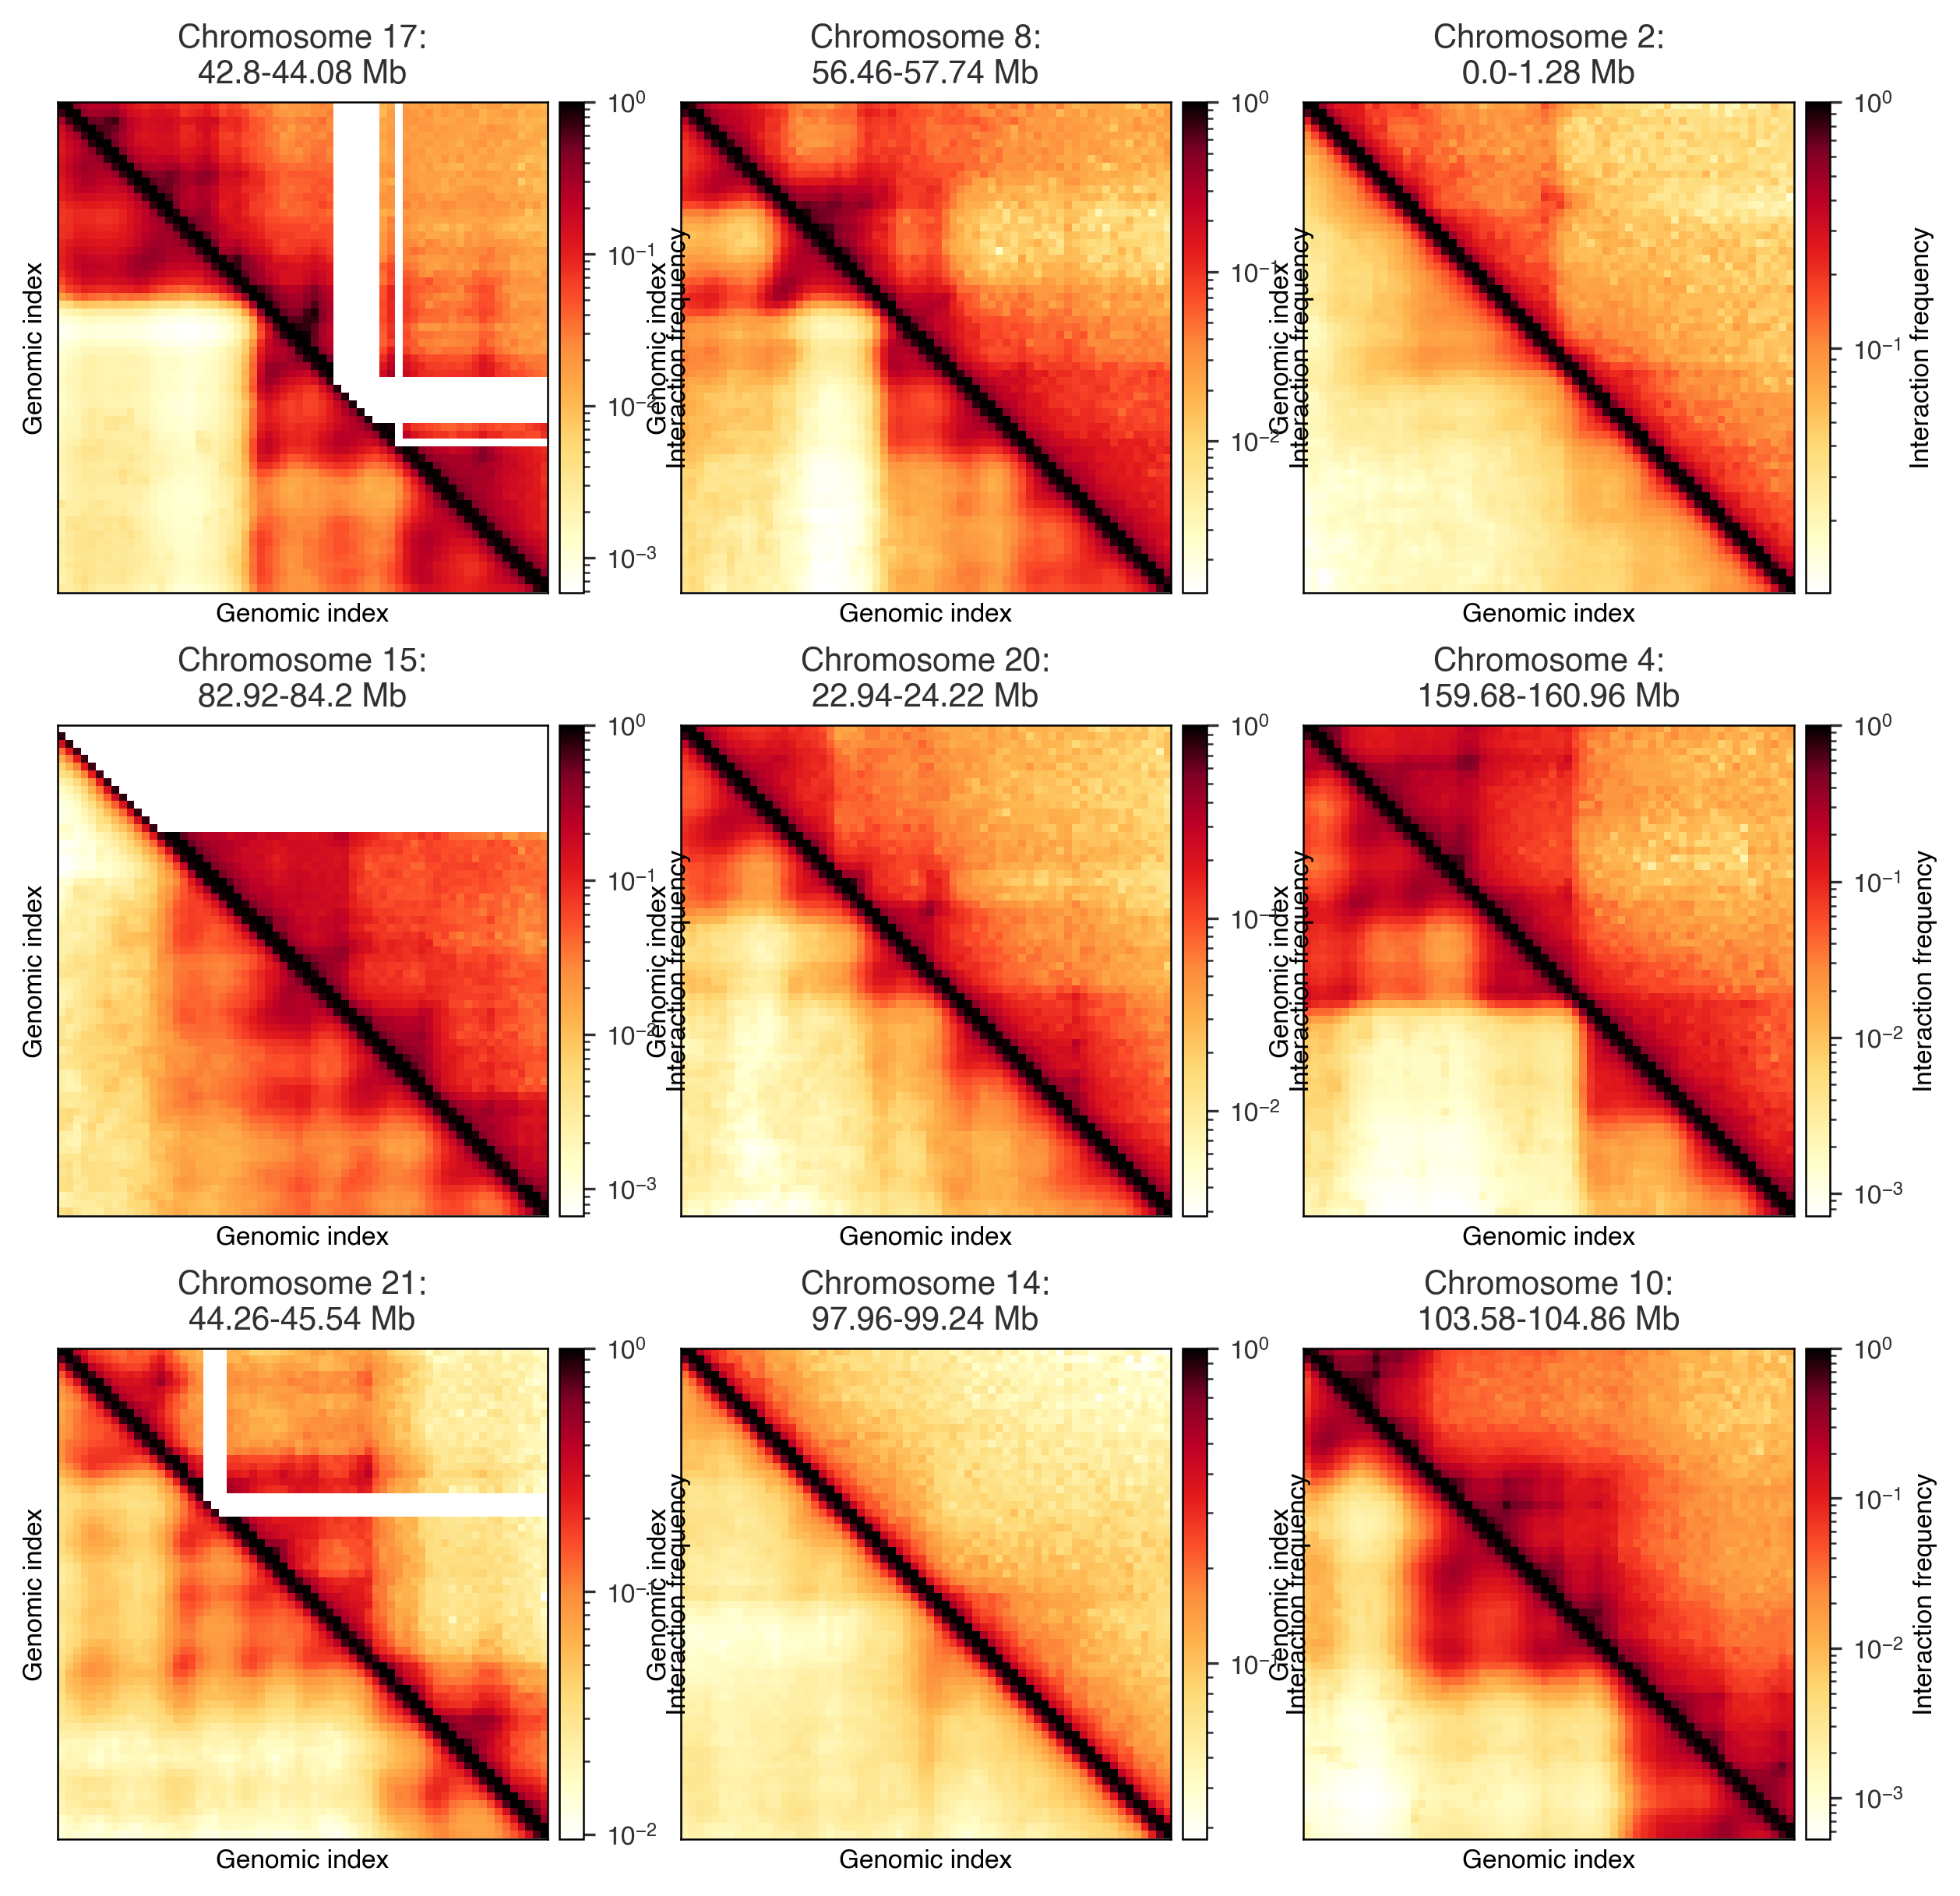

In [22]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
while k < 9:
    ax = axes[k//3,k%3]

    coord_fp1 = all_gm_coord_files[-k-1]
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    
    fig, ax, im, cbar = plot_region(coord_fp1,coord_fp2,gm_hic,fig=fig,ax=ax)
    k+=1
    

Text(0.5, 0.98, 'Fraction $w=1$ contribution: 0.8')

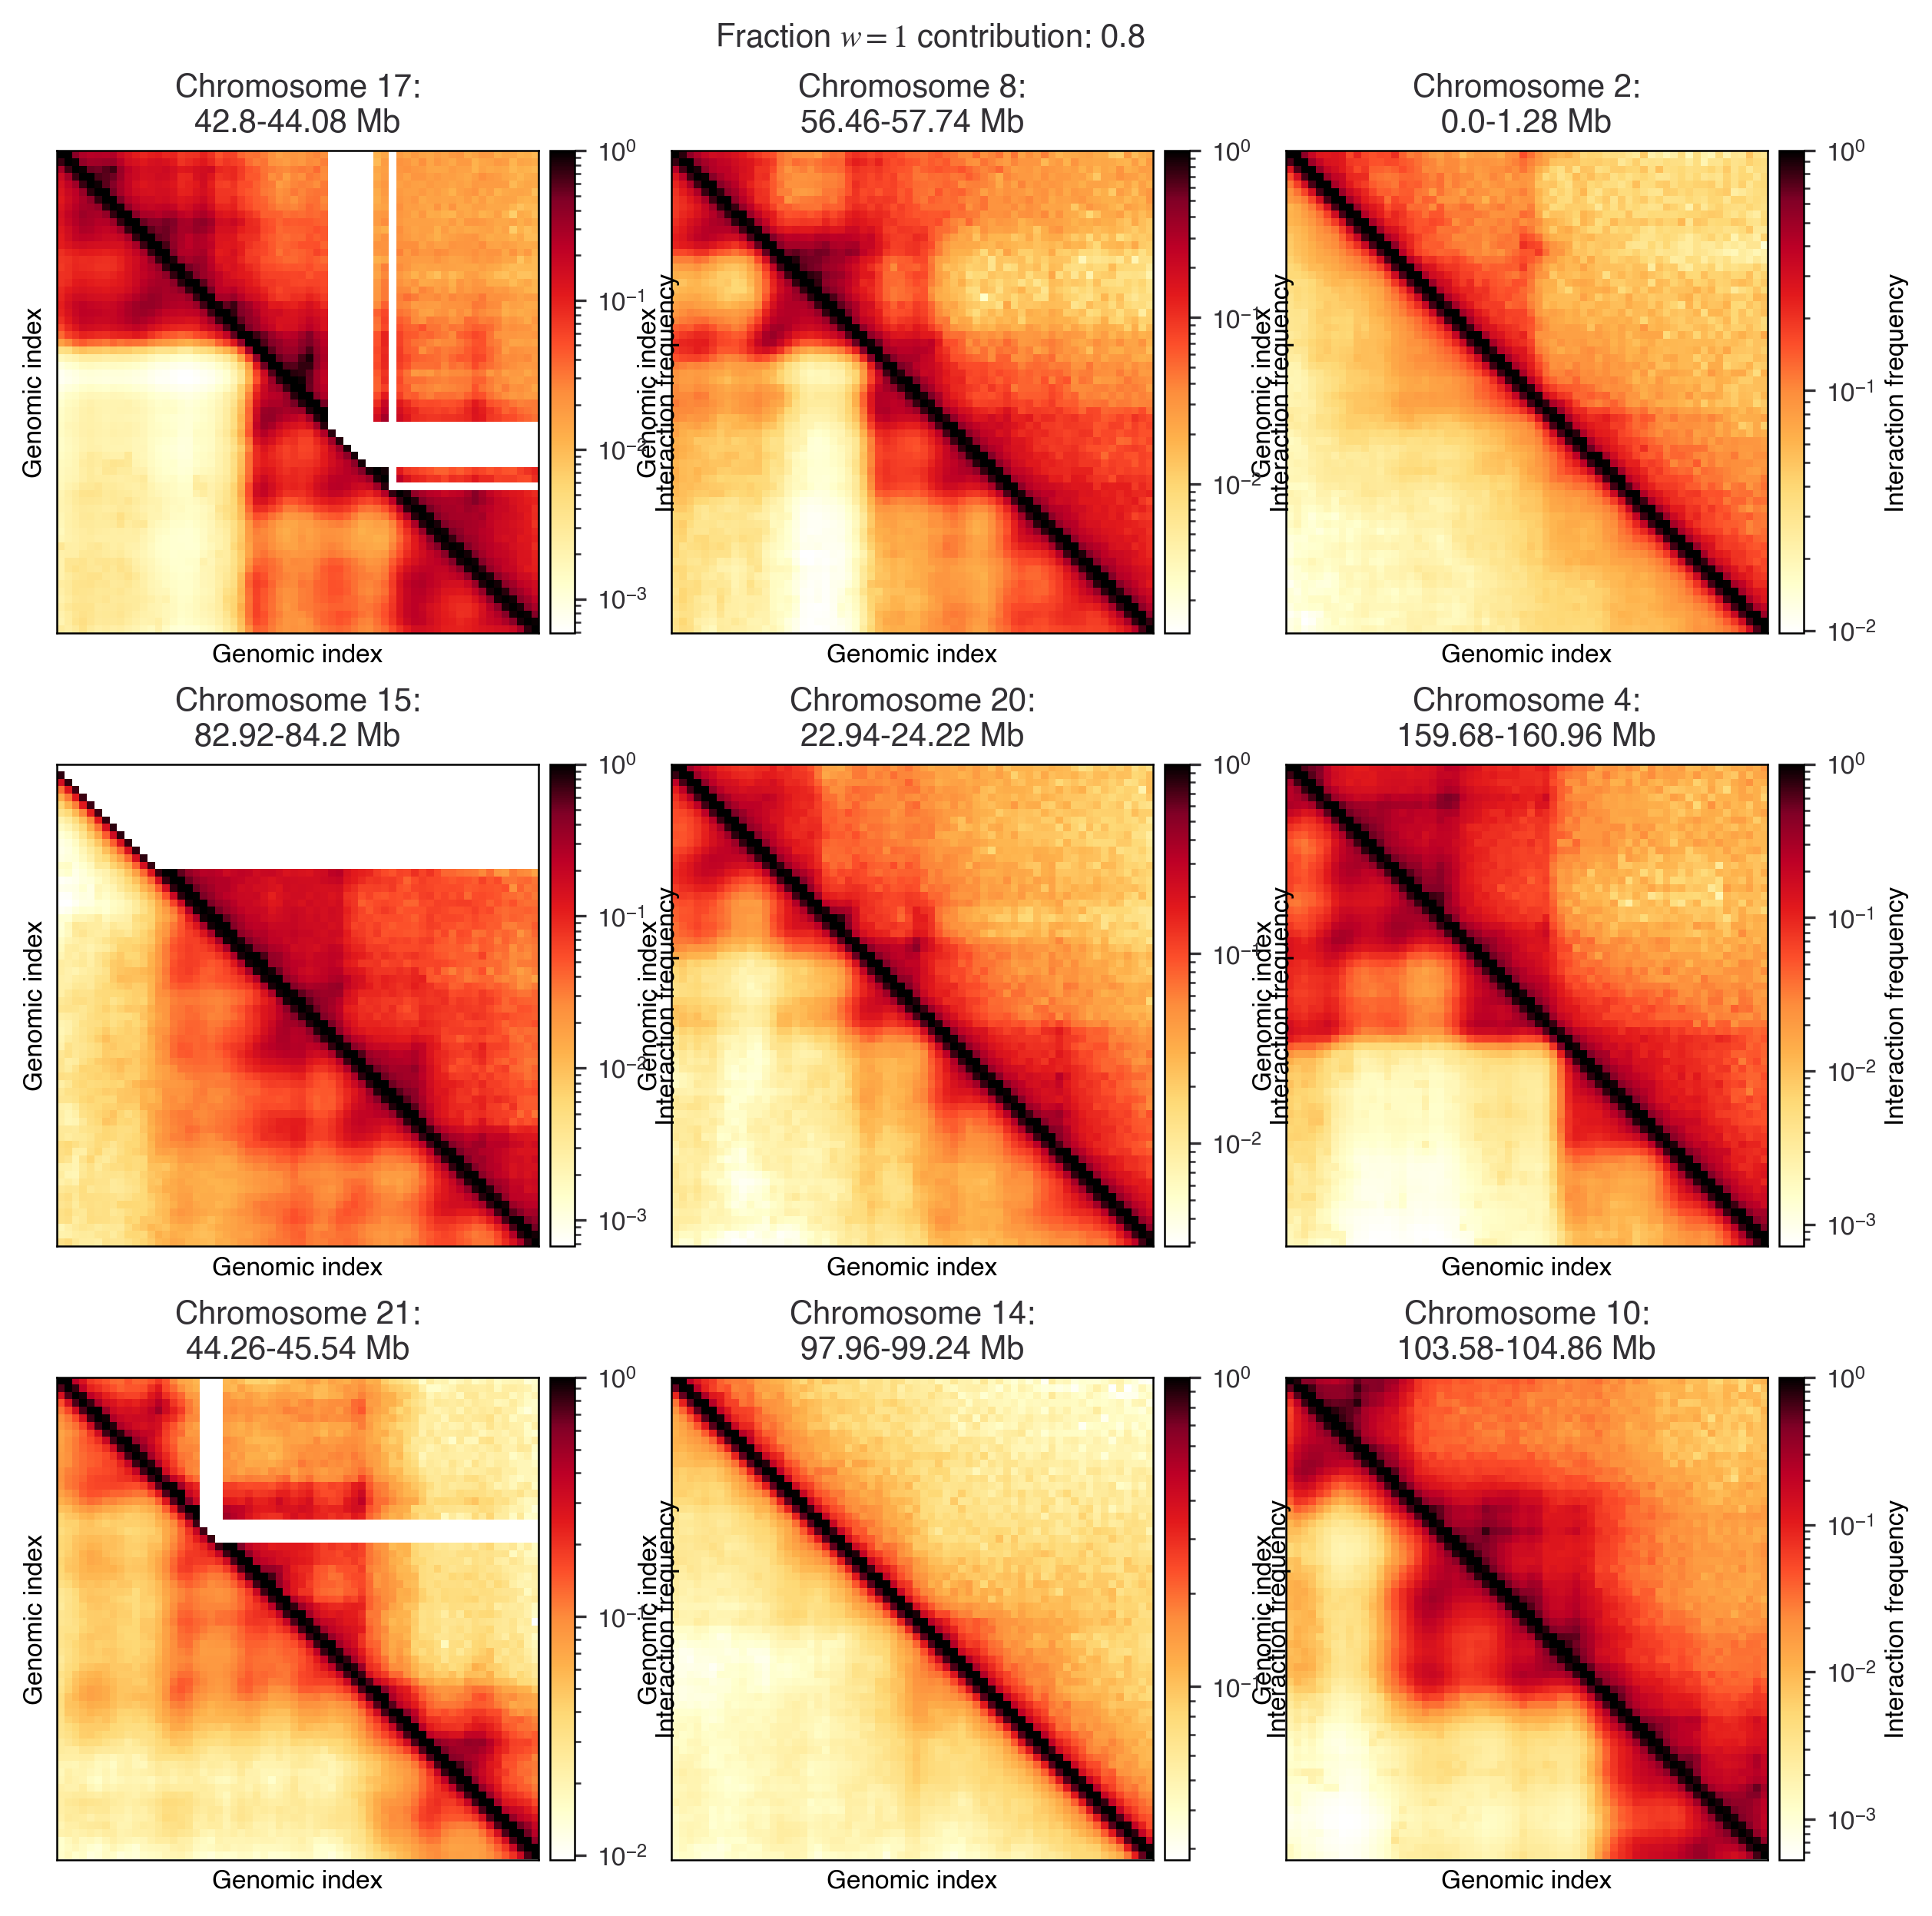

In [23]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8.2))
k=0
n=0
ratio = 0.8
while k < 9:
    ax = axes[k//3,k%3]

    coord_fp1 = all_gm_coord_files[-k-1]
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    
    fig, ax, im, cbar = plot_region(coord_fp1,coord_fp2,gm_hic,fig=fig,ax=ax,ratio=ratio)
    k+=1
fig.suptitle(f'Fraction $w=1$ contribution: {ratio}')

Text(0.5, 0.98, 'Fraction $w=1$ contribution: 0.5')

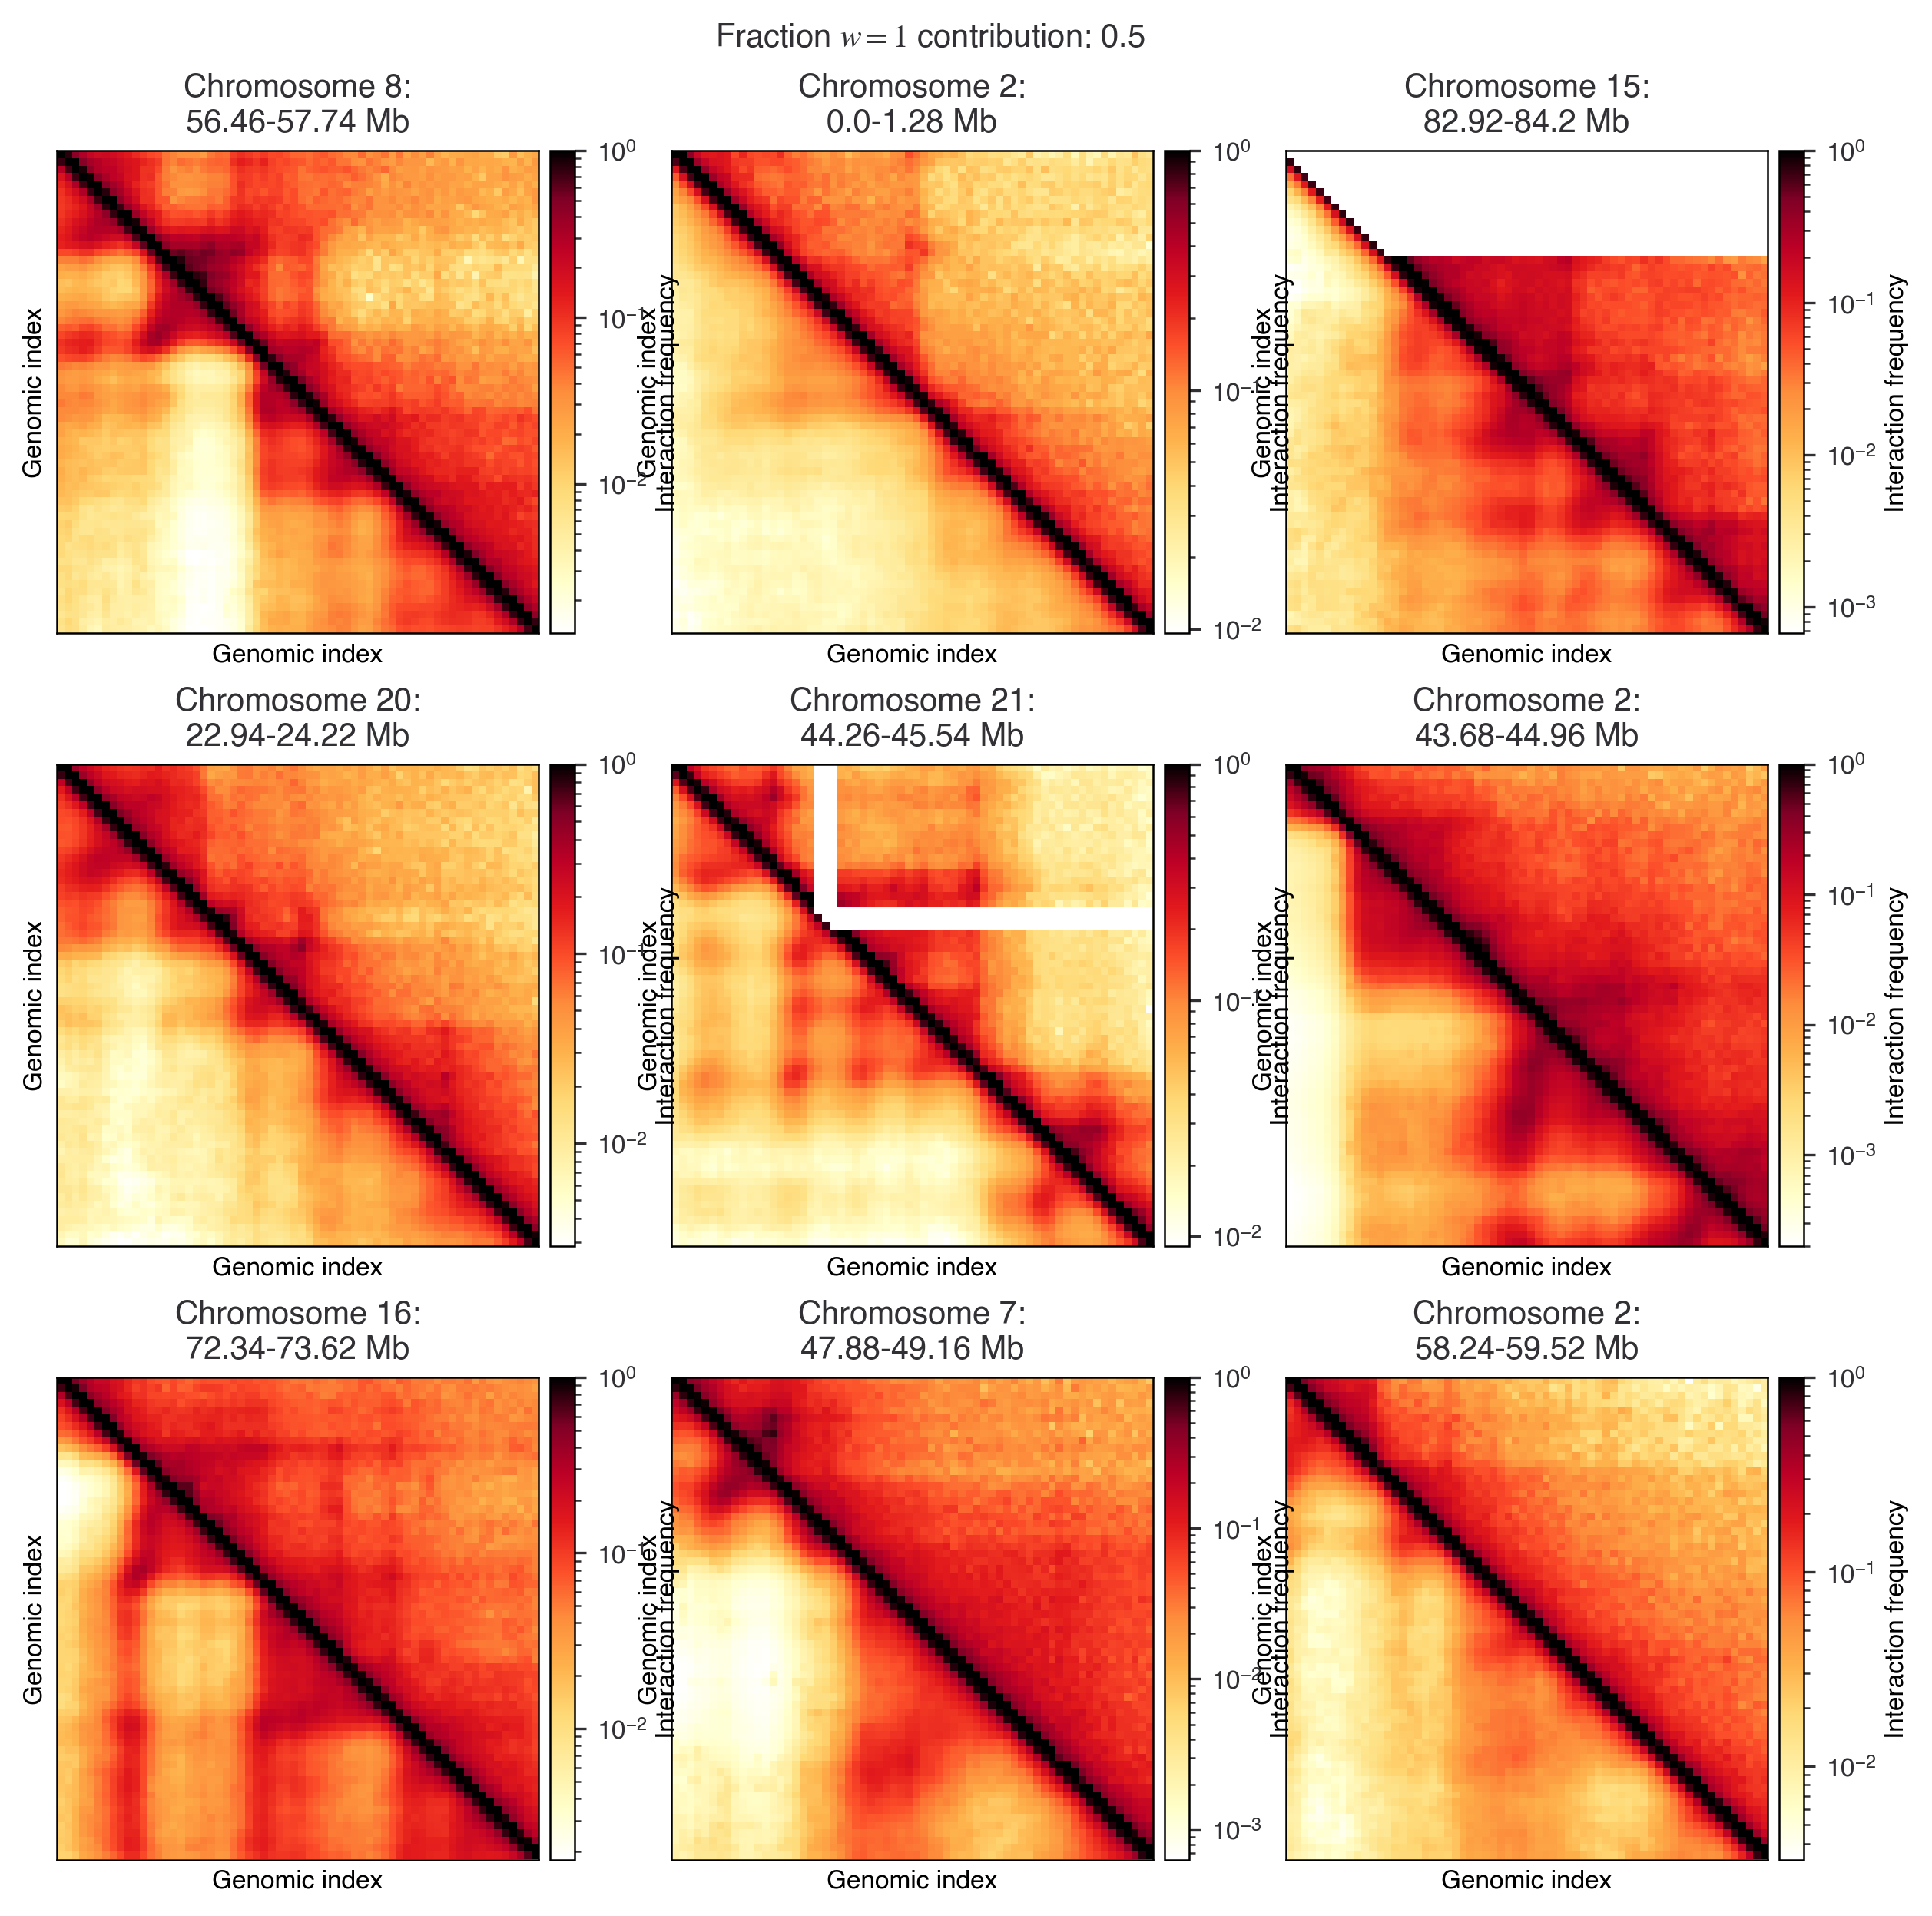

In [24]:
'''
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
n=0
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-n],gm_hic,fig=fig,ax=ax)
    k+=1
'''

fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8.2))
k=0
n=0
ratio = 0.5
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]

    coord_fp1 = all_gm_coord_files[-n]
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    
    fig, ax, im, cbar = plot_region(coord_fp1,coord_fp2,gm_hic,fig=fig,ax=ax,ratio=ratio)
    k+=1
fig.suptitle(f'Fraction $w=1$ contribution: {ratio}')
    

Text(0.5, 0.98, 'Fraction $w=1$ contribution: 0.5')

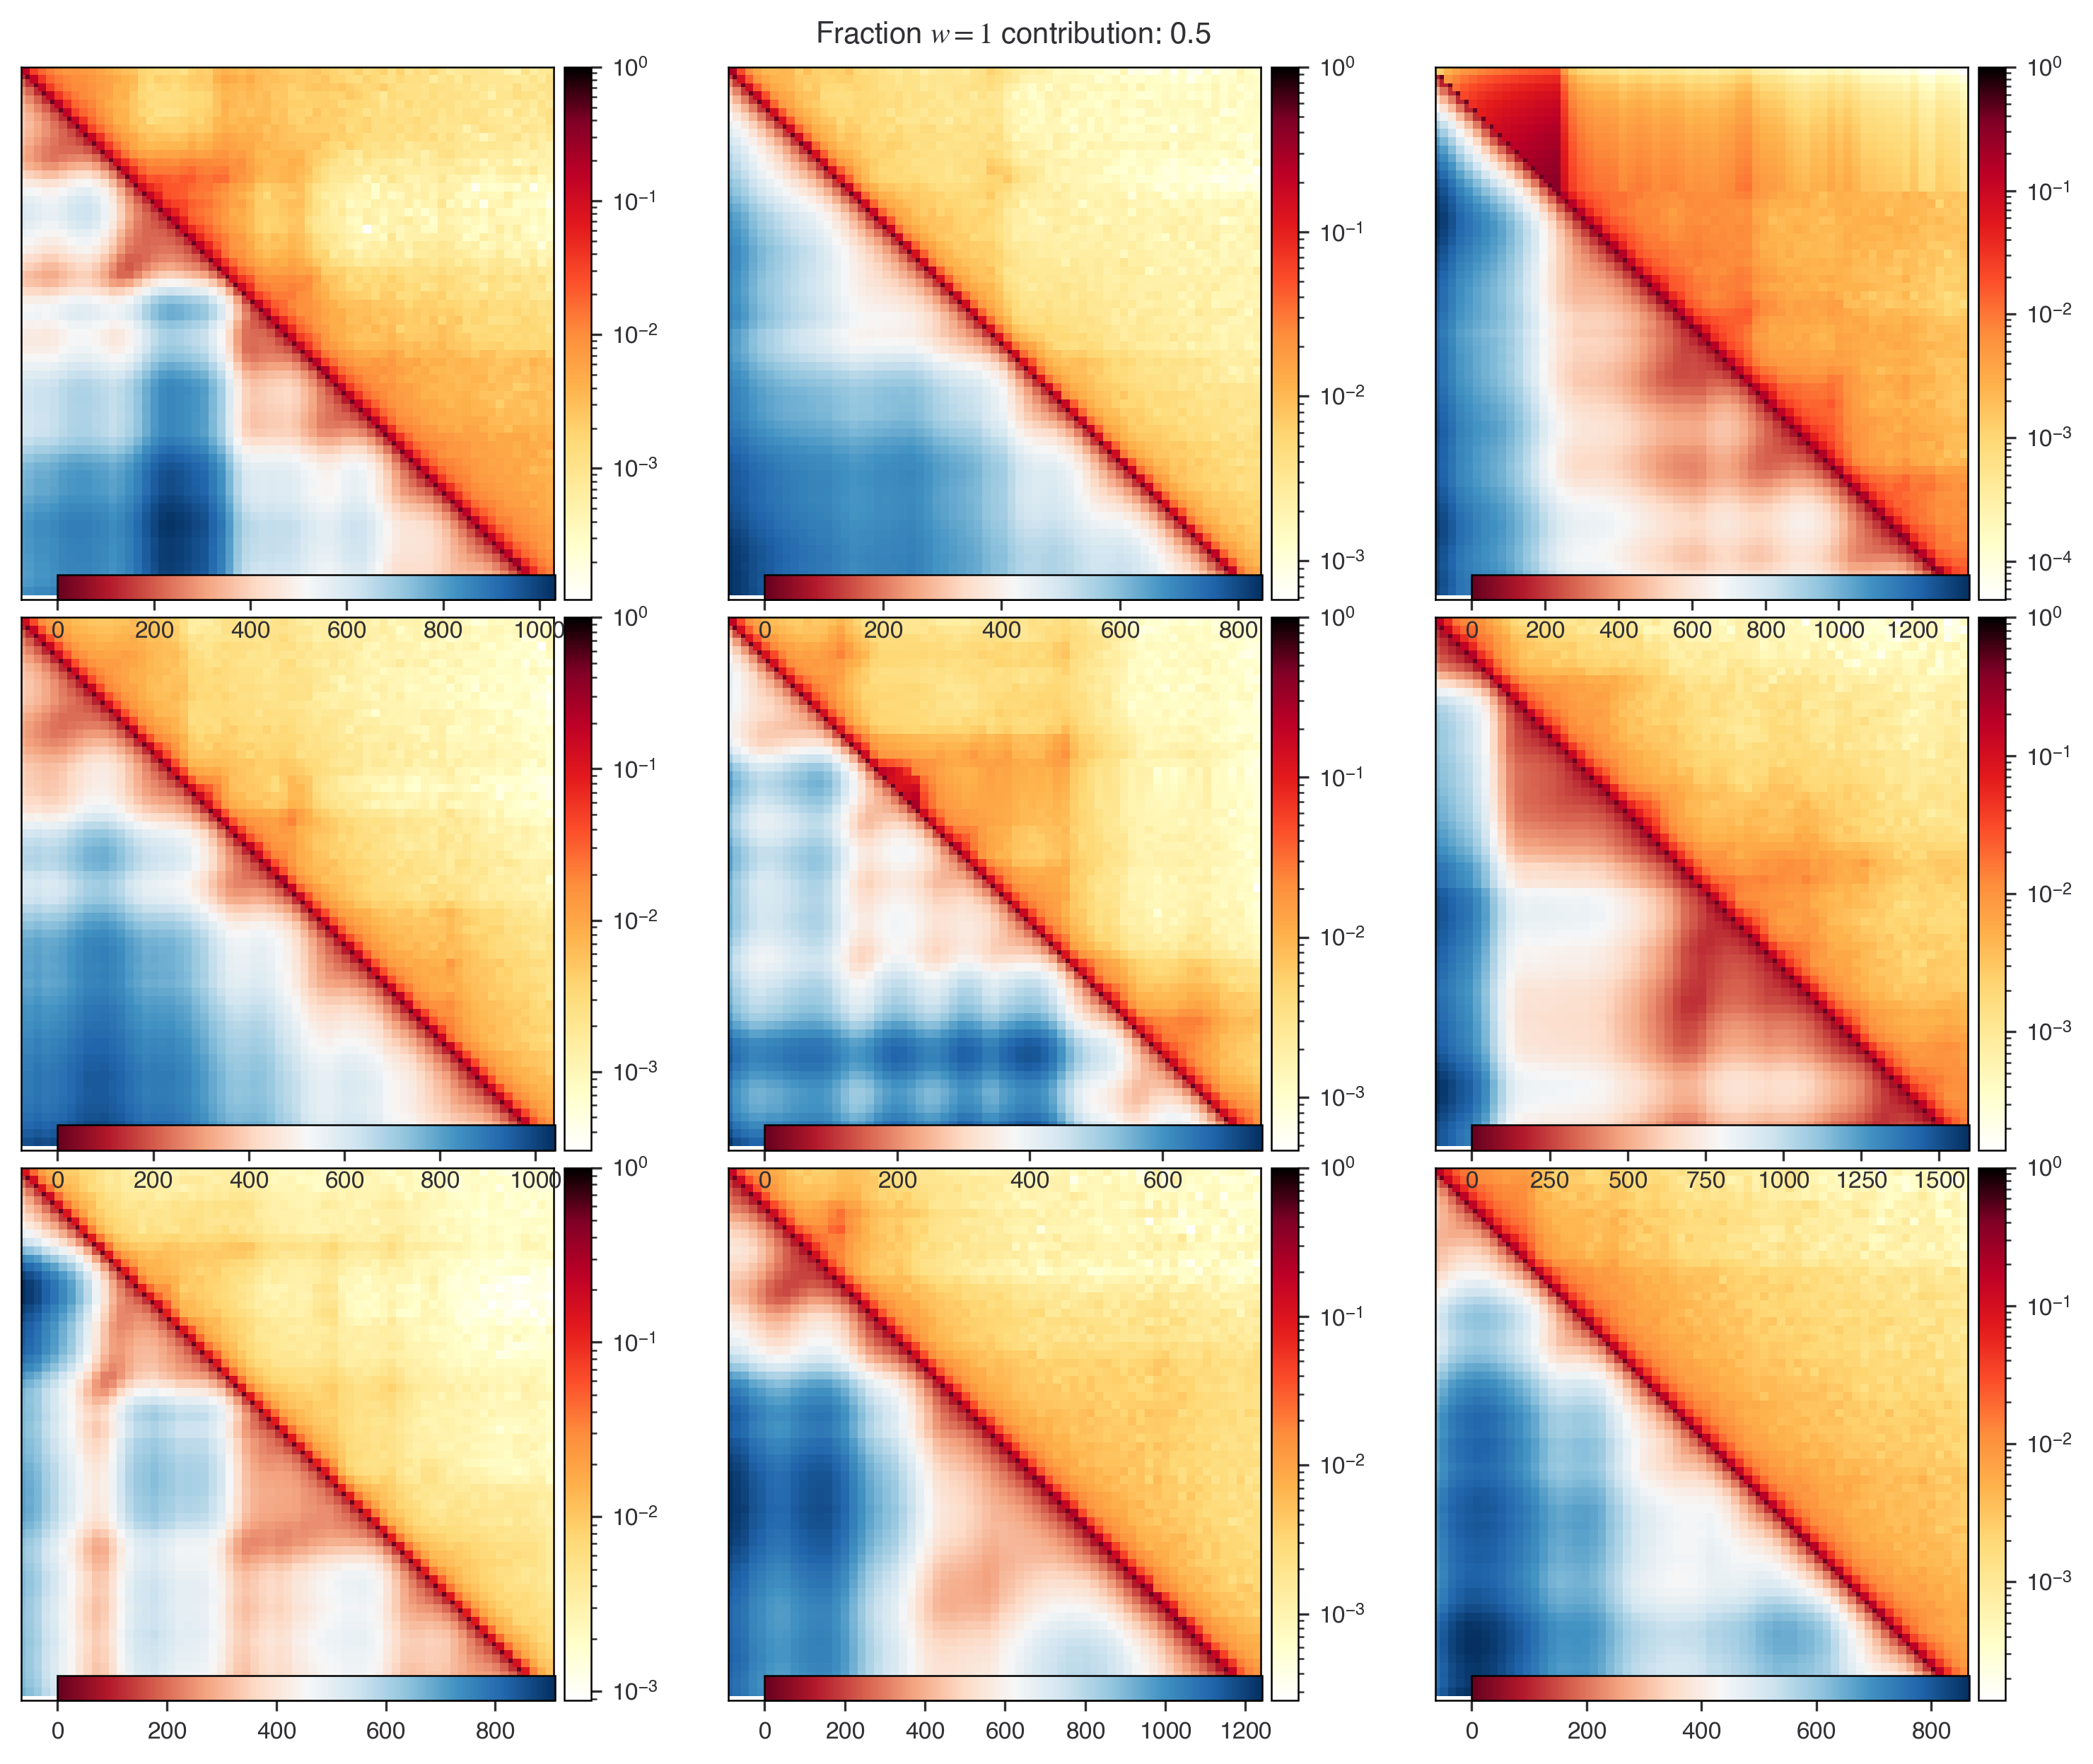

In [25]:
'''
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
n=0
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-n],gm_hic,fig=fig,ax=ax)
    k+=1
'''

fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(10,8))
k=0
n=0
ratio = 0.5
i,j = torch.triu_indices(64,64,1)
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]

    coord_fp1 = all_gm_coord_files[-n]
    coord_fp2 = data_dir2 + coord_fp1.split('/')[-1]
    coord_fp2 = coord_fp2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    coord_fp2 = coord_fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))

    mixed_dists = Coordinates(coord_fp1).distances.mean
    mixed_dists._values*= ratio
    mixed_dists._values+= Coordinates(coord_fp2).distances.mean.values * (1-ratio)
    mixed_dists._values*= 100
    
    fig, ax, im, cbar = mixed_dists.plot(fig=fig,ax=ax,cbar_orientation='horizontal') #plot_region(coord_fp1,coord_fp2,gm_hic,fig=fig,ax=ax,ratio=ratio)
    cbar.set_label('')
    
    chrom,_,start = parse_filename(coord_fp1)
    stop = start + 1_280_000
    exp_map = gm_hic.fetch(chrom,start,stop,interp_nans=True)
    exp_map.prob_map[j,i] = torch.nan
    *_,cbar = exp_map.plot(fig=fig,ax=ax)
    cbar.set_label('')
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    
    k+=1
fig.suptitle(f'Fraction $w=1$ contribution: {ratio}')
    

#### Compute all R-squared, correlation values

In [26]:
corr_dist = {}
r2_prob = {}
corr_prob = {}

# There are multiple ways to construct the combined generated structure, so bootstrap the median value. 
# This defines the number of bootstrapping resamplings to perform. 
n_bootstrap_resamples = 100

# Perform computations on the GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

fraction_w1s_to_test = [.5] 

for cell_type,files,exp_hic in [
    ('GM',all_gm_coord_files,gm_hic),
    ('IMR',all_imr_coord_files,imr_hic),
    ('Tan',all_gm_coord_files,gm_hic)
]:

    data_fp_ = data_fp(cell_type)

    if os.path.exists(data_fp_):
        temp_data = pickle.load(open(data_fp_,'rb'))
        temp_corr_dist = temp_data['corr_dist']
        temp_r2_prob = temp_data['r2_prob']
        temp_corr_prob = temp_data['corr_prob']
        del temp_data
    else:
        temp_corr_dist = {}
        temp_r2_prob = {}
        temp_corr_prob = {}

    # Decide which w=1 vs w=5 fractions to look at
    if cell_type == 'Tan':
        fractions = [0] # Experimental data has no weighting split to consider
    else:
        fractions = fraction_w1s_to_test

    # Track whether changes are made such that the data will need to be saved
    modified = False 
    for fraction_w1 in fractions:
        if fraction_w1 in temp_corr_dist:
            continue

        modified = True # The data WILL change/need to be saved
        
        gen_median_dists = []
        gen_probs = []
        exp_probs = []
        exp_log_probs = []

        for f in tqdm(files):
            
            # Determine the chromosome, region index, and genomic index
            chrom, region_idx, genomic_index = parse_filename(f)
    
            # Load the generated coordinates
            if cell_type == 'Tan':
                coords1 = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
            else:
                coords1 = Coordinates(f)
            coords1 = coords1.to(device) 
            inferred_prob_map = conformations_to_probs(coords1)
                
            coords1.to_(inferred_prob_map.device)
            
            # Load the experimental Hi-C interaction frequencies
            start = genomic_index
            stop = start + resolution * coords1.num_beads
            exp_prob_map = exp_hic.fetch(chrom,start,stop)
    
            # Get the indices for the upper triangle of each set of data, excluding the diagonal
            n = coords1.num_beads
            i,j = torch.triu_indices(n,n,1,device=exp_prob_map.device)
    
            #####
            # Place data into the respective lists
    
            # Interaction frequency
            exp_probs.append(exp_prob_map.prob_map[i,j])
            
            # Remove values associated with NaN Hi-C data
            valid_idx = torch.where(exp_probs[-1].isfinite())[0]
            exp_probs[-1] = exp_probs[-1][valid_idx]
            i,j = i[valid_idx], j[valid_idx]
    
            # Normalize the experimental interaction frequencies to nearest neighbors to
            # obtain contact probabilities consistent with our distance-to-probability 
            # conversion
            exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
            
            # Log probability
            exp_log_probs.append(exp_probs[-1].log10())
            
            # Generated probabilities
            gen_probs.append(inferred_prob_map.prob_map[i,j])
            
            # Interactions with recorded probability 0 become undefined, so remove those points
            valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
            exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
            i,j = i[valid_idx], j[valid_idx]
    
            # Generated distances
            if cell_type != 'Tan':
                coords1,coords2 = get_gen_coords(f)
                dists1 = coords1.distances
                dists2 = coords2.distances
                dists1._values*= 100
                dists2._values*= 100
                n1 = len(dists1)
                n2 = len(dists2)
                N = n1 + n2
                median_dist_resamples = []
                for _ in range(n_bootstrap_resamples):
    
                    # Decide how many samples to draw from each 
                    # set of conformations
                    nn1 = ( torch.rand(N) < ratio ).sum()
                    nn2 = N - nn1
    
                    # Draw samples to construct new dataset, find median dists, record result
                    median_dist_resamples.append(
                        dists1[torch.randint(n1,(nn1,))].append(
                            dists2[torch.randint(n2,(nn2,))]
                        ).median.values
                    )
            
                # Record the median of medians
                gen_median_dists.append(
                    torch.cat(median_dist_resamples,dim=0).median(0).values[i,j]
                )
            else:
                gen_median_dists.append(coords1.distances.median.values[0,i,j])
    
        # Compute the desired statistics
        if len(gen_median_dists) > 0:
            cd = batch_corrcoef(gen_median_dists,exp_log_probs).cpu()
            r2p = batch_r2(gen_probs,exp_probs).cpu()
            cp = batch_corrcoef(gen_probs,exp_probs).cpu()
        else:
            cd = []
            r2p = []
            cp = []

        del gen_median_dists, exp_log_probs, gen_probs, exp_probs

        temp_corr_dist[fraction_w1] = cd
        temp_r2_prob[fraction_w1] = r2p
        temp_corr_prob[fraction_w1] = cp

    if modified:
        pickle.dump(
            {
                'corr_dist':temp_corr_dist,
                'r2_prob':temp_r2_prob,
                'corr_prob':temp_corr_prob
            },
            open(data_fp_,'wb')
        )
    
    corr_dist[cell_type] = temp_corr_dist
    r2_prob[cell_type] = temp_r2_prob
    corr_prob[cell_type] = temp_corr_prob


In [27]:
# Reformat to what was initially intended
if 'Tan' in corr_dist:

    corr_dist['Tan'] = corr_dist['Tan'][0]
    r2_prob['Tan'] = r2_prob['Tan'][0]
    corr_prob['Tan'] = corr_prob['Tan'][0]

for fraction_w1 in corr_dist['GM']:
    for object in [corr_dist,r2_prob,corr_prob]:
        object[fraction_w1] = {
            'GM':object['GM'][fraction_w1],
            'IMR':object['IMR'][fraction_w1]
        }
    

from tqdm.auto import tqdm 

# Number of resamplings to perform during bootstrapping to get median distance
n_bootstrap_resamples = 100

if os.path.exists(data_fp):
    data = pickle.load(open(data_fp,'rb'))
    corr_dist = data['corr_dist']
    #corr_dist = {}
    corr_mean_dist = data['corr_mean_dist']
    r2_prob = data['r2_prob']
    corr_prob = data['corr_prob']

    # temporary...
    #corr_dist.pop('Tan')
    #r2_prob.pop('Tan')
    #corr_prob.pop('Tan')

else:
    #r2_dist = {}
    corr_dist = {}
    r2_prob = {}
    corr_prob = {}

modified = False
for ratio in [.5]:#[0.,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.]:

    if ratio not in corr_dist:
        #r2_dist[ratio] = {}
        corr_dist[ratio] = {}
        r2_prob[ratio] = {}
        corr_prob[ratio] = {}

    #if 'GM' in corr_dist[ratio] and 'IMR' in corr_dist[ratio] and 'Tan' in corr_dist:
    #    continue
    
    for cell_type,files,exp_hic in [
        ('GM',all_gm_coord_files,gm_hic),
        ('IMR',all_imr_coord_files,imr_hic),
        ('Tan',all_gm_coord_files,gm_hic)
    ]:
    
        gen_median_dists = []
        gen_probs = []
        exp_probs = []
        exp_log_probs = []

        if cell_type in corr_dist[ratio]:# and not cell_type == 'IMR':
            continue
        
        for f in tqdm(files):
            
            # Determine the chromosome, region index, and genomic index
            chrom, region_idx, genomic_index = parse_filename(f)
    
            # Load the generated coordinates
            if cell_type == 'Tan':
                coords1 = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
                gen_prob_map = conformations_to_probs(coords1)
            else:
                coords1 = Coordinates(f)
                gen_prob_map,mean_dists = get_gen_data(f,fraction=ratio)
            coords1.to_(gen_prob_map.device)
    
            # Convert coordinates to distances and obtain the average contact probabilities
            #dists = coords.distances
            #gen_prob_map = conformations_to_probs(dists)
            
            # Load the experimental Hi-C interaction frequencies
            start = genomic_index
            stop = start + resolution * coords1.num_beads
            exp_prob_map = exp_hic.fetch(chrom,start,stop)
    
            # Get the indices for the upper triangle of each set of data, excluding the diagonal
            n = coords1.num_beads
            i,j = torch.triu_indices(n,n,1,device=exp_prob_map.device)
    
            #####
            # Place data into the respective lists
    
            # Interaction frequency
            exp_probs.append(exp_prob_map.prob_map[i,j])
            
            # Remove values associated with NaN Hi-C data
            valid_idx = torch.where(exp_probs[-1].isfinite())[0]
            exp_probs[-1] = exp_probs[-1][valid_idx]
            i,j = i[valid_idx], j[valid_idx]
    
            # Normalize the experimental interaction frequencies to nearest neighbors to
            # obtain contact probabilities consistent with our distance-to-probability 
            # conversion
            exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
            
            # Log probability
            exp_log_probs.append(exp_probs[-1].log10())
            
            # Generated probabilities
            gen_probs.append(gen_prob_map.prob_map[i,j])
            
            # Interactions with recorded probability 0 become undefined, so remove those points
            valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
            exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
            i,j = i[valid_idx], j[valid_idx]
    
            # Generated distances
            if cell_type != 'Tan':
                coords1,coords2 = get_gen_coords(f)
                dists1 = coords1.distances
                dists2 = coords2.distances
                dists1._values*= 100
                dists2._values*= 100
                n1 = len(dists1)
                n2 = len(dists2)
                N = n1 + n2
                median_dist_resamples = []
                for _ in range(n_bootstrap_resamples):
    
                    # Decide how many samples to draw from each 
                    # set of conformations
                    nn1 = ( torch.rand(N) < ratio ).sum()
                    nn2 = N - nn1
    
                    # Draw samples to construct new dataset, find median dists, record result
                    median_dist_resamples.append(
                        dists1[torch.randint(n1,(nn1,))].append(
                            dists2[torch.randint(n2,(nn2,))]
                        ).median.values
                    )
            
                # Record the median of medians
                gen_median_dists.append(
                    torch.cat(median_dist_resamples,dim=0).median(0).values[i,j]
                )
            else:
                gen_median_dists.append(coords1.distances.median.values[0,i,j])
            
            #gen_median_dists.append(dists.median.values[0,i,j])
            #gen_median_dists.append(mean_dists.values[0,i,j])
    
        # Compute the desired statistics
        if len(gen_median_dists) > 0:
            cd = batch_corrcoef(gen_median_dists,exp_log_probs)
            r2p = batch_r2(gen_probs,exp_probs)
            cp = batch_corrcoef(gen_probs,exp_probs)
        else:
            cd = []
            r2p = []
            cp = []

        if cell_type == 'Tan':
            corr_dist[cell_type] = cd.cpu()
            r2_prob[cell_type] = r2p.cpu()
            corr_prob[cell_type] = cp.cpu()
        else:
            corr_dist[ratio][cell_type] = cd.cpu()
            r2_prob[ratio][cell_type] = r2p.cpu()
            corr_prob[ratio][cell_type] = cp.cpu()
        '''
        if len(gen_median_dists) > 0:
            #r2_dist[ratio][cell_type] = batch_r2(gen_median_dists,exp_log_probs) 
            corr_dist[ratio][cell_type] = batch_corrcoef(gen_median_dists,exp_log_probs)
            r2_prob[ratio][cell_type] = batch_r2(gen_probs,exp_probs)
            corr_prob[ratio][cell_type] = batch_corrcoef(gen_probs,exp_probs)
        else:
            #r2_dist[ratio][cell_type] = []
            corr_dist[ratio][cell_type] = []
            r2_prob[ratio][cell_type] = []
            corr_prob[ratio][cell_type] = []
        '''

        modified = True

if modified:
    pickle.dump(
        {
            'corr_mean_dist':corr_mean_dist,
            'corr_dist':corr_dist,
            'r2_prob':r2_prob,
            'corr_prob':corr_prob
        },
        open(data_fp,'wb')
    )


pickle.dump(
    {
        'corr_mean_dist':corr_mean_dist,
        'corr_dist':corr_dist,
        'r2_prob':r2_prob,
        'corr_prob':corr_prob
    },
    open(data_fp.replace('.pt','_v2.pt'),'wb')
)

i,j = torch.triu_indices(64,64,1)

gen_median_dists1 = []

for k,gmd in enumerate(gen_median_dists):

    gen_median_dists1.append(gmd.clone())
    gen_median_dists[k] = gmd[i,j]

#gen_median_dists1 = gen_median_dists.clone()
#gen_median_dists = gen_median_dists[0,i,j]

#### Make the plots

In [28]:
def plot_hist(data1,data2,tag1,tag2,nbins=25,fig=None,ax=None,alpha=0.5,bins=None):

    # Convert to numpy to improve speed in plt 
    data1 = data1.cpu().numpy()
    data2 = data2.cpu().numpy()

    # Create consistent bins for eaach data type
    if bins is None:
        minn = min(data1.min(),data2.min())
        maxx = max(data1.max(),data2.max())
        #minn = gm_data.min()
        #maxx = gm_data.max()
        delta = (maxx-minn)/nbins
        bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(data1,alpha=alpha,bins=bins,label=tag1,edgecolor='none',density=True)
    ax.hist(data2,alpha=alpha,bins=bins,label=tag2,edgecolor='none',density=True)

    return fig, ax
    

    
    
    
    

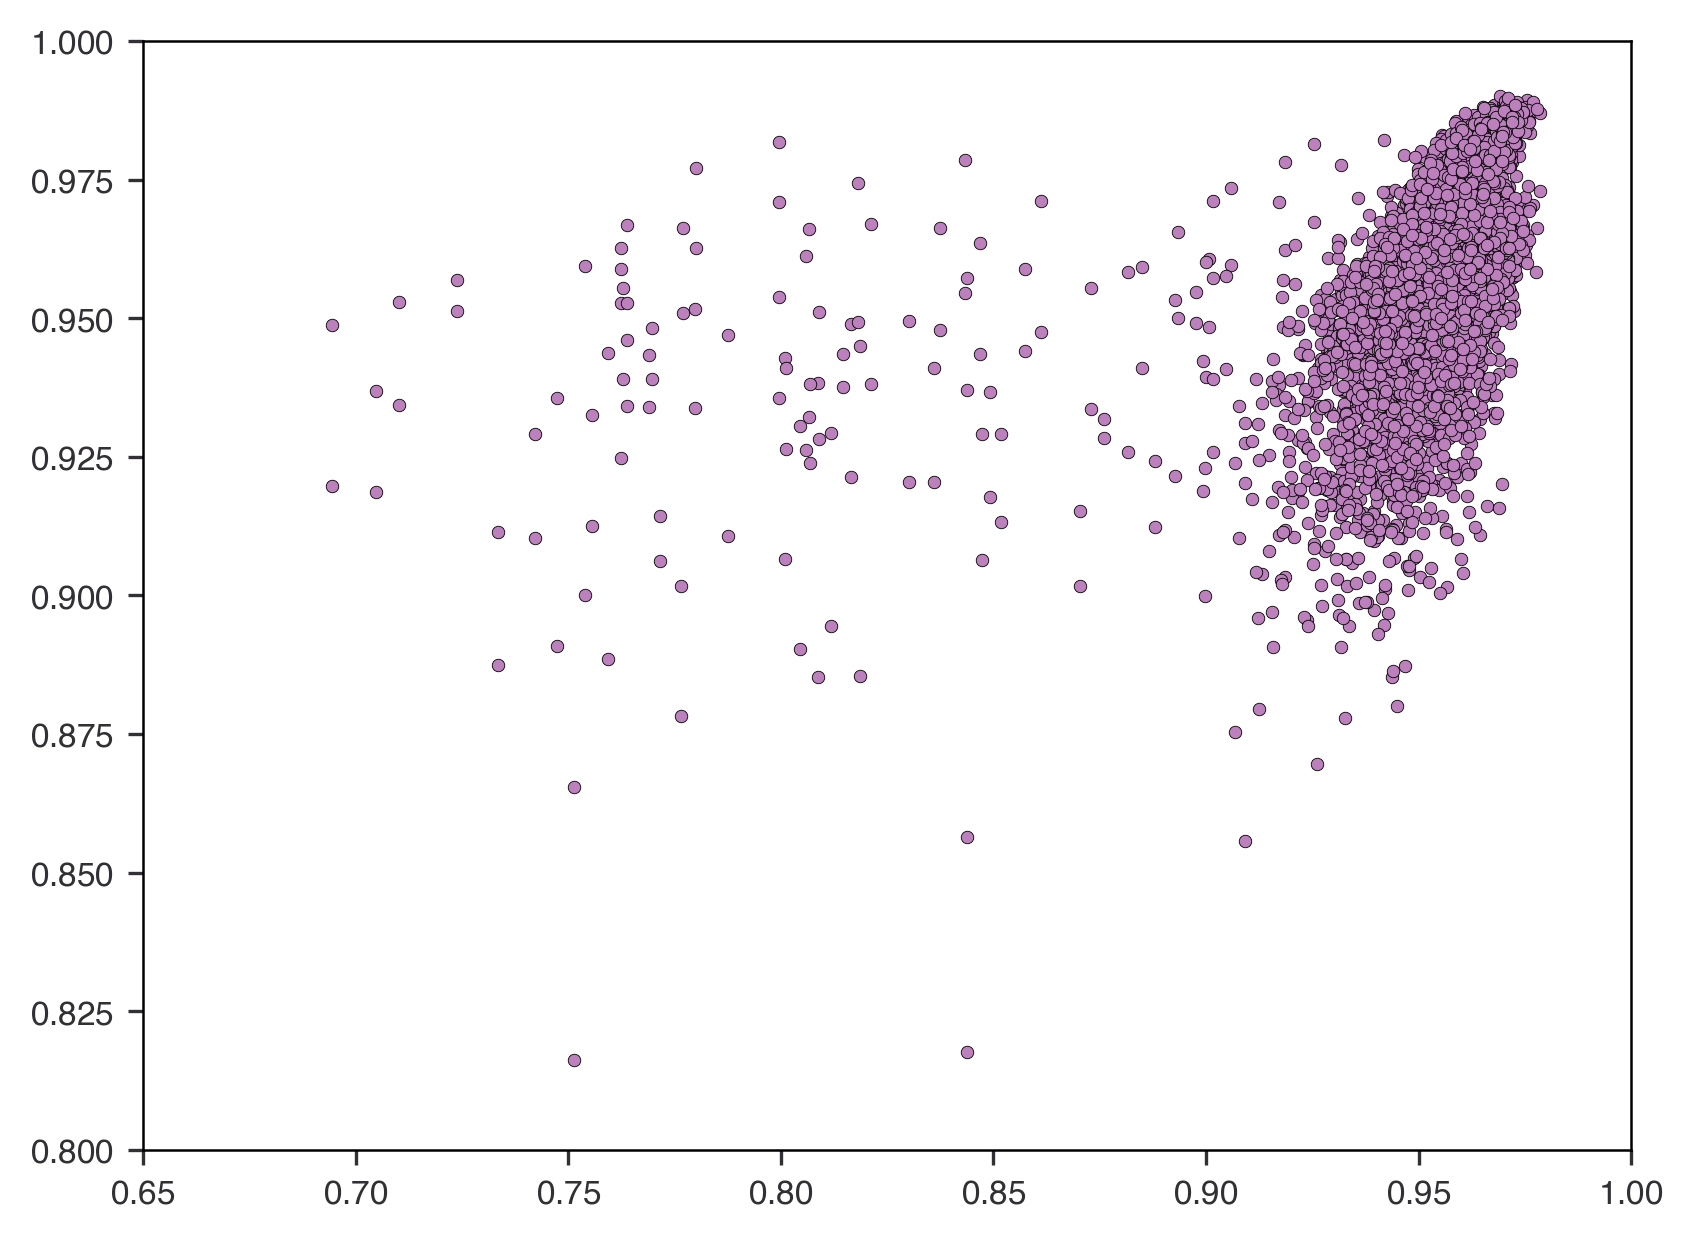

In [29]:
#plt.hist(corr_prob[ratio]['GM'].flatten().cpu().numpy(),alpha=.5)
#plt.hist(corr_prob['Tan'].flatten().cpu().numpy(),alpha=.5)

plt.plot(corr_prob['Tan'].flatten().cpu().numpy(),corr_prob[ratio]['GM'].flatten().cpu().numpy(),'.')

tensor(-0.9351, dtype=torch.float64)
tensor(0.9573, dtype=torch.float64)
tensor(0.7753, dtype=torch.float64)


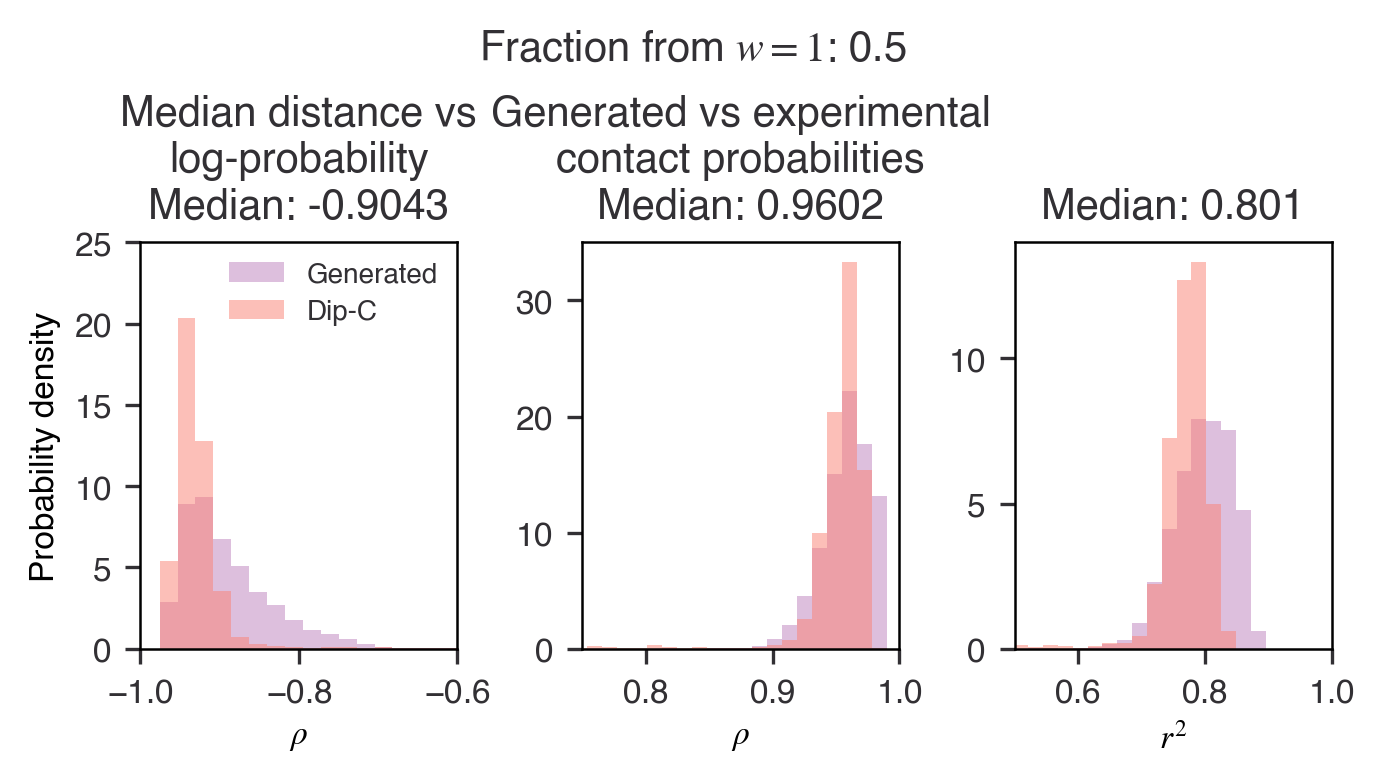

In [30]:
for ratio in fraction_w1s_to_test:#[key for key in corr_dist.keys() if key != 'Tan']:

    fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,2.5))

    xlabels = [
        '$\\rho$',
        '$\\rho$',
        '$r^2$'
    ]
    titles = [
        'Median distance vs\nlog-probability',
        'Generated vs experimental\ncontact probabilities',
        ''
    ]
    
    # R2-scores
    for i,(r2_GM,r2_tan) in enumerate([ (corr_dist[ratio]['GM'],corr_dist['Tan']), 
                                       (corr_prob[ratio]['GM'],corr_prob['Tan']), 
                                       (r2_prob[ratio]['GM'],r2_prob['Tan']) ]):
        ax = axes[i]
        fig,ax = plot_hist(r2_GM,r2_tan,'Generated','Dip-C',fig=fig,ax=ax)
        ax.set_xlabel(xlabels[i])
        if i == 0:
            ax.set_xlim([-1,-.6])
        
        ax.set_title(titles[i] + '\n' + f'Median: {round(r2_GM.median().tolist(),4)}')
        if i == 0:
            #ax.set_ylabel('Number of\ntested regions')
            ax.set_ylabel('Probability density')
            ax.legend(framealpha=0,loc='upper right',fontsize='small')
            ax.set_xlim([-1,-.6])

        if i == 1:
            ax.set_xlim([.75,1])
        
        
        if i == 2:
            ax.set_xlim([.5,1])
            ax.set_yticks([0,5,10],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$'])

        print(r2_tan.median())

    fig.suptitle(f'Fraction from $w=1$: {ratio}')
    #fig.savefig(save_folder+f'HiCCorrelationR2_{ratio}.pdf',transparent=True)

    

for ratio in r2_dist:
    print(f'FRACTION: {ratio}')
    print('r2_dist',min(r2_dist[ratio]['GM']).tolist(),max(r2_dist[ratio]['GM']).tolist())
    print('corr_dist',min(corr_dist[ratio]['GM']).tolist(),max(corr_dist[ratio]['GM']).tolist())
    print('r2_prob',min(r2_prob[ratio]['GM']).tolist(),max(r2_prob[ratio]['GM']).tolist())
    print('corr_prob',min(corr_prob[ratio]['GM']).tolist(),max(corr_prob[ratio]['GM']).tolist())
    print('')

tensor(-0.9043, dtype=torch.float64)
tensor(0.9602, dtype=torch.float64)
tensor(0.8010, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'M', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 38, 39, 42, 48, 51, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef

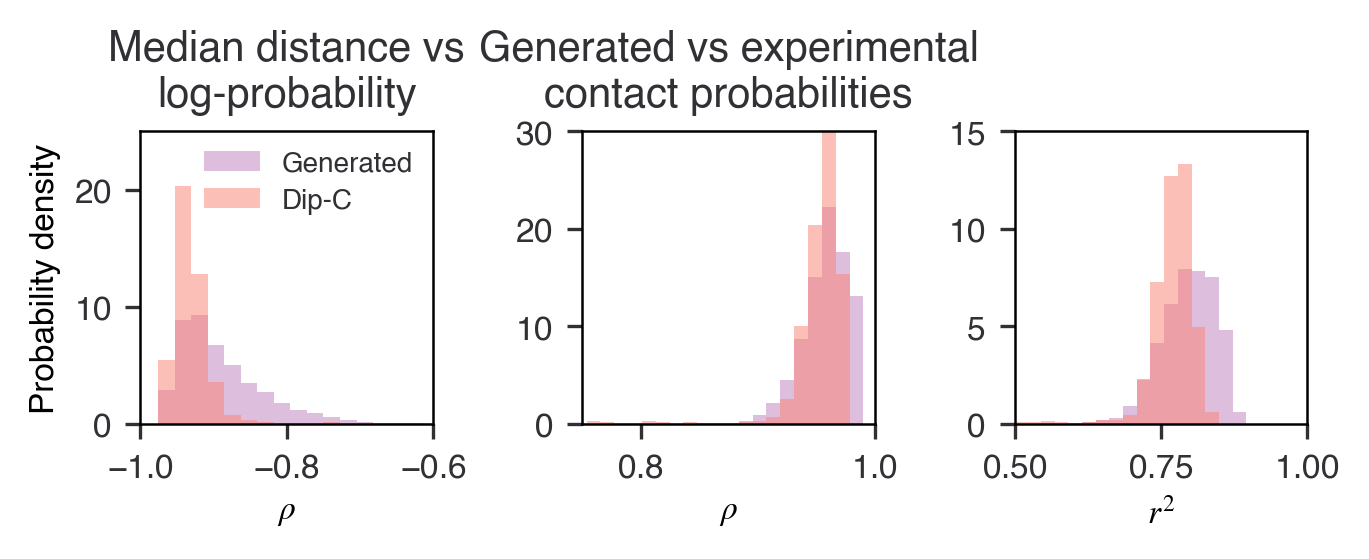

In [31]:
fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))

xlabels = [
    '$\\rho$',
    '$\\rho$',
    '$r^2$'
]
titles = [
    'Median distance vs\nlog-probability',
    'Generated vs experimental\ncontact probabilities',
    ''
]

# R2-scores
ratio = .5 
for i,(r2_GM,r2_tan) in enumerate([(corr_dist[ratio]['GM'],corr_dist['Tan']), 
                                   (corr_prob[ratio]['GM'],corr_prob['Tan']), 
                                   (r2_prob[ratio]['GM'],r2_prob['Tan']) ]):
    ax = axes[i]
    fig,ax = plot_hist(r2_GM,r2_tan,'Generated','Dip-C',fig=fig,ax=ax)
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    if i == 0:
        ax.set_xlim([-1,-.6])
        #ax.set_ylabel('Number of\ntested regions')
        ax.set_ylabel('Probability density')
        ax.legend(framealpha=0,loc='upper right',fontsize='small')
    elif i == 1:
        ax.set_xlim([.75,1])
        ax.set_ylim([0,30])
    elif i == 2:
        ax.set_xlim([.5,1])
        ax.set_yticks([0,5,10,15],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$'])

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()

    ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )

    print(r2_GM.median())

fig.savefig(save_folder+'HiCCorrelationR2_2.pdf')#,transparent=True)
    

### Same plot, but IMR

In [32]:
def plot_hist_2(data,nbins=25,fig=None,ax=None,alpha=0.5,set_bin_data=None):

    # set_bin_data is used to ensure bins are roughly the same as in the GM plots 
    
    # Convert to numpy to improve speed in plt 
    data = data.cpu().numpy()

    if set_bin_data is None:
        set_bin_data = data
    
    # Create consistent bins for eaach data type
    minn = min(set_bin_data.min(),data.min())
    maxx = max(set_bin_data.max(),data.max())
    #minn = gm_data.min()
    #maxx = gm_data.max()
    
    delta = (maxx-minn)/nbins
    bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(data,alpha=alpha,bins=bins,edgecolor='none',density=True)

    return fig, ax

tensor(-0.8867, dtype=torch.float64)
tensor(0.9463, dtype=torch.float64)
tensor(0.7921, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'M', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 42, 48, 51, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 36 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', '

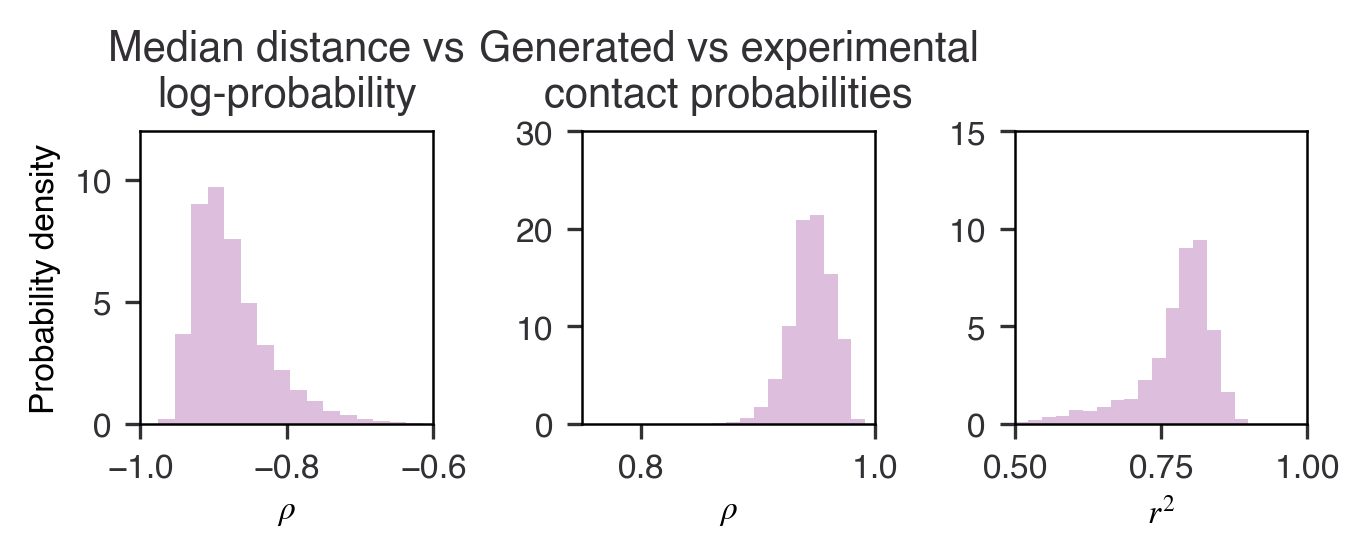

In [33]:
fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))

xlabels = [
    '$\\rho$',
    '$\\rho$',
    '$r^2$'
]
titles = [
    'Median distance vs\nlog-probability',
    'Generated vs experimental\ncontact probabilities',
    ''
]

# R2-scores
ratio = .5 
for i,(r2_IMR,r2_GM,r2_tan) in enumerate([(corr_dist[ratio]['IMR'],corr_dist[ratio]['GM'],corr_dist['Tan']), 
                                   (corr_prob[ratio]['IMR'],corr_prob[ratio]['GM'],corr_prob['Tan']), 
                                   (r2_prob[ratio]['IMR'],r2_prob[ratio]['GM'],r2_prob['Tan'])]):
    ax = axes[i]
    fig,ax = plot_hist_2(r2_IMR,fig=fig,ax=ax,set_bin_data=torch.cat([r2_GM,r2_tan]))
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    if i == 0:
        ax.set_xlim([-1,-.6])
        #ax.set_ylabel('Number of\ntested regions')
        ax.set_ylabel('Probability density')
        ax.legend(framealpha=0,loc='upper right',fontsize='small')
    elif i == 1:
        ax.set_xlim([.75,1])
        ax.set_ylim([0,30])
    elif i == 2:
        ax.set_xlim([.5,1])
        ax.set_yticks([0,5,10,15],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$'])

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()

    ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )

    print(r2_IMR.median())

fig.savefig(save_folder+'HiCCorrelationR2_IMR.pdf')#,transparent=True)
    

tensor(-0.8867, dtype=torch.float64)
tensor(0.9463, dtype=torch.float64)
tensor(0.7921, dtype=torch.float64)


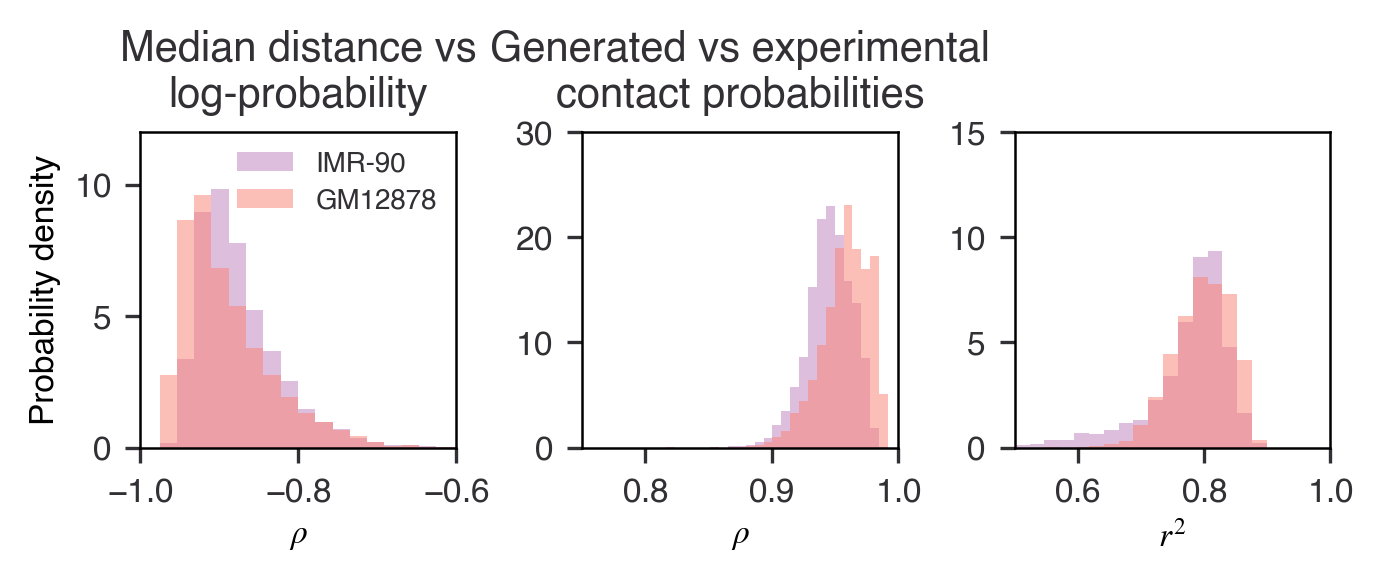

In [34]:
fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))

xlabels = [
    '$\\rho$',
    '$\\rho$',
    '$r^2$'
]
titles = [
    'Median distance vs\nlog-probability',
    'Generated vs experimental\ncontact probabilities',
    ''
]

# R2-scores
ratio = .5 
for i,(r2_IMR,r2_GM,r2_tan) in enumerate([(corr_dist[ratio]['IMR'],corr_dist[ratio]['GM'],corr_dist['Tan']), 
                                   (corr_prob[ratio]['IMR'],corr_prob[ratio]['GM'],corr_prob['Tan']), 
                                   (r2_prob[ratio]['IMR'],r2_prob[ratio]['GM'],r2_prob['Tan'])]):
    ax = axes[i]
    #fig,ax = plot_hist_2(r2_IMR,fig=fig,ax=ax,set_bin_data=torch.cat([r2_GM,r2_tan]))
    fig,ax = plot_hist(r2_IMR,r2_GM,'IMR-90','GM12878',fig=fig,ax=ax)
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    if i == 0:
        ax.set_xlim([-1,-.6])
        #ax.set_ylabel('Number of\ntested regions')
        ax.set_ylabel('Probability density')
        ax.legend(framealpha=0,loc='upper right',fontsize='small')
    elif i == 1:
        ax.set_xlim([.75,1])
        ax.set_ylim([0,30])
    elif i == 2:
        ax.set_xlim([.5,1])
        ax.set_yticks([0,5,10,15],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$'])

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()

    ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )

    print(r2_IMR.median())

#fig.savefig(save_folder+'HiCCorrelationR2_2.pdf')#,transparent=True)
    

#### Same plots, but separating chromosome X

Define the bins to use in the plots

In [35]:
nbins = 25

minns = {
    'corr_dist':2,
    'r2_prob':2,
    'corr_prob':2
}

maxxs = {
    'corr_dist':-2,
    'r2_prob':-2,
    'corr_prob':-2
}

for data_name in ['X','no_X']:

    corr_dist = {}
    r2_prob = {}
    corr_prob = {}
    
    # There are multiple ways to construct the combined generated structure, so bootstrap the median value. 
    # This defines the number of bootstrapping resamplings to perform. 
    n_bootstrap_resamples = 100
    
    # Perform computations on the GPU if possible
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    
    fraction_w1s_to_test = [.5] 
    
    for cell_type,files,exp_hic in [
        ('GM',all_gm_coord_files,gm_hic),
        ('IMR',all_imr_coord_files,imr_hic),
        ('Tan',all_gm_coord_files,gm_hic)
    ]:
    
        data_fp_ = data_fp(cell_type + '_' + data_name)
    
        if os.path.exists(data_fp_):
            temp_data = pickle.load(open(data_fp_,'rb'))
            temp_corr_dist = temp_data['corr_dist']
            temp_r2_prob = temp_data['r2_prob']
            temp_corr_prob = temp_data['corr_prob']
            del temp_data
        else:
            temp_corr_dist = {}
            temp_r2_prob = {}
            temp_corr_prob = {}
    
        # Decide which w=1 vs w=5 fractions to look at
        if cell_type == 'Tan':
            fractions = [0] # Experimental data has no weighting split to consider
        else:
            fractions = fraction_w1s_to_test
    
        # Track whether changes are made such that the data will need to be saved
        modified = False 
        for fraction_w1 in fractions:
            if fraction_w1 in temp_corr_dist:
                continue
    
            modified = True # The data WILL change/need to be saved
            
            gen_median_dists = []
            gen_probs = []
            exp_probs = []
            exp_log_probs = []
    
            for f in tqdm(files):
                
                # Determine the chromosome, region index, and genomic index
                chrom, region_idx, genomic_index = parse_filename(f)
        
                # Load the generated coordinates
                if cell_type == 'Tan':
                    coords1 = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
                else:
                    coords1 = Coordinates(f)
                coords1 = coords1.to(device) 
                inferred_prob_map = conformations_to_probs(coords1)
                    
                coords1.to_(inferred_prob_map.device)
                
                # Load the experimental Hi-C interaction frequencies
                start = genomic_index
                stop = start + resolution * coords1.num_beads
                exp_prob_map = exp_hic.fetch(chrom,start,stop)
        
                # Get the indices for the upper triangle of each set of data, excluding the diagonal
                n = coords1.num_beads
                i,j = torch.triu_indices(n,n,1,device=exp_prob_map.device)
        
                #####
                # Place data into the respective lists
        
                # Interaction frequency
                exp_probs.append(exp_prob_map.prob_map[i,j])
                
                # Remove values associated with NaN Hi-C data
                valid_idx = torch.where(exp_probs[-1].isfinite())[0]
                exp_probs[-1] = exp_probs[-1][valid_idx]
                i,j = i[valid_idx], j[valid_idx]
        
                # Normalize the experimental interaction frequencies to nearest neighbors to
                # obtain contact probabilities consistent with our distance-to-probability 
                # conversion
                exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
                
                # Log probability
                exp_log_probs.append(exp_probs[-1].log10())
                
                # Generated probabilities
                gen_probs.append(inferred_prob_map.prob_map[i,j])
                
                # Interactions with recorded probability 0 become undefined, so remove those points
                valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
                exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
                i,j = i[valid_idx], j[valid_idx]
        
                # Generated distances
                if cell_type != 'Tan':
                    coords1,coords2 = get_gen_coords(f)
                    dists1 = coords1.distances
                    dists2 = coords2.distances
                    dists1._values*= 100
                    dists2._values*= 100
                    n1 = len(dists1)
                    n2 = len(dists2)
                    N = n1 + n2
                    median_dist_resamples = []
                    for _ in range(n_bootstrap_resamples):
        
                        # Decide how many samples to draw from each 
                        # set of conformations
                        nn1 = ( torch.rand(N) < ratio ).sum()
                        nn2 = N - nn1
        
                        # Draw samples to construct new dataset, find median dists, record result
                        median_dist_resamples.append(
                            dists1[torch.randint(n1,(nn1,))].append(
                                dists2[torch.randint(n2,(nn2,))]
                            ).median.values
                        )
                
                    # Record the median of medians
                    gen_median_dists.append(
                        torch.cat(median_dist_resamples,dim=0).median(0).values[i,j]
                    )
                else:
                    gen_median_dists.append(coords1.distances.median.values[0,i,j])
        
            # Compute the desired statistics
            if len(gen_median_dists) > 0:
                cd = batch_corrcoef(gen_median_dists,exp_log_probs).cpu()
                r2p = batch_r2(gen_probs,exp_probs).cpu()
                cp = batch_corrcoef(gen_probs,exp_probs).cpu()
            else:
                cd = []
                r2p = []
                cp = []
    
            del gen_median_dists, exp_log_probs, gen_probs, exp_probs
    
            temp_corr_dist[fraction_w1] = cd
            temp_r2_prob[fraction_w1] = r2p
            temp_corr_prob[fraction_w1] = cp
    
        if modified:
            pickle.dump(
                {
                    'corr_dist':temp_corr_dist,
                    'r2_prob':temp_r2_prob,
                    'corr_prob':temp_corr_prob
                },
                open(data_fp_,'wb')
            )
        
        corr_dist[cell_type] = temp_corr_dist
        r2_prob[cell_type] = temp_r2_prob
        corr_prob[cell_type] = temp_corr_prob
    
    
    # Reformat to what was initially intended
    if 'Tan' in corr_dist:
    
        corr_dist['Tan'] = corr_dist['Tan'][0]
        r2_prob['Tan'] = r2_prob['Tan'][0]
        corr_prob['Tan'] = corr_prob['Tan'][0]
    
    for fraction_w1 in corr_dist['GM']:
        for object in [corr_dist,r2_prob,corr_prob]:
            object[fraction_w1] = {
                'GM':object['GM'][fraction_w1],
                'IMR':object['IMR'][fraction_w1]
            }

    minns['corr_dist'] = min(minns['corr_dist'],corr_dist['GM'][fraction_w1].min(),corr_dist['IMR'][fraction_w1].min(),corr_dist['Tan'].min())
    minns['r2_prob'] = min(minns['r2_prob'],r2_prob['GM'][fraction_w1].min(),r2_prob['IMR'][fraction_w1].min(),r2_prob['Tan'].min())
    minns['corr_prob'] = min(minns['corr_prob'],corr_prob['GM'][fraction_w1].min(),corr_prob['IMR'][fraction_w1].min(),corr_prob['Tan'].min())

    maxxs['corr_dist'] = max(maxxs['corr_dist'],corr_dist['GM'][fraction_w1].max(),corr_dist['IMR'][fraction_w1].max(),corr_dist['Tan'].max())
    maxxs['r2_prob'] = max(maxxs['r2_prob'],r2_prob['GM'][fraction_w1].max(),r2_prob['IMR'][fraction_w1].max(),r2_prob['Tan'].min())
    maxxs['corr_prob'] = max(maxxs['corr_prob'],corr_prob['GM'][fraction_w1].max(),corr_prob['IMR'][fraction_w1].max(),corr_prob['Tan'].max())

all_bins = {}
for k in ['corr_dist','r2_prob','corr_prob']:

    minn = minns[k]
    maxx = maxxs[k]
    delta = (maxx-minn)/nbins
    all_bins[k] = torch.arange(minn,maxx+delta/2,delta)
    

X: GM12878
tensor(-0.9234, dtype=torch.float64)
tensor(0.9737, dtype=torch.float64)
tensor(0.8240, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'M', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 25, 27, 28, 38, 39, 42, 48, 51, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef'

X: IMR-90
tensor(-0.8966, dtype=torch.float64)
tensor(0.9663, dtype=torch.float64)
tensor(0.8198, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'I', 'M', 'P', 'R', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 42, 44, 48, 51, 53, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph name

no_X: GM12878
tensor(-0.9262, dtype=torch.float64)
tensor(0.9682, dtype=torch.float64)
tensor(0.8084, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'M', 'P', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 25, 27, 28, 38, 39, 42, 48, 51, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef'

no_X: IMR-90
tensor(-0.9029, dtype=torch.float64)
tensor(0.9533, dtype=torch.float64)
tensor(0.7928, dtype=torch.float64)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'I', 'M', 'P', 'R', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 42, 44, 48, 51, 53, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph name

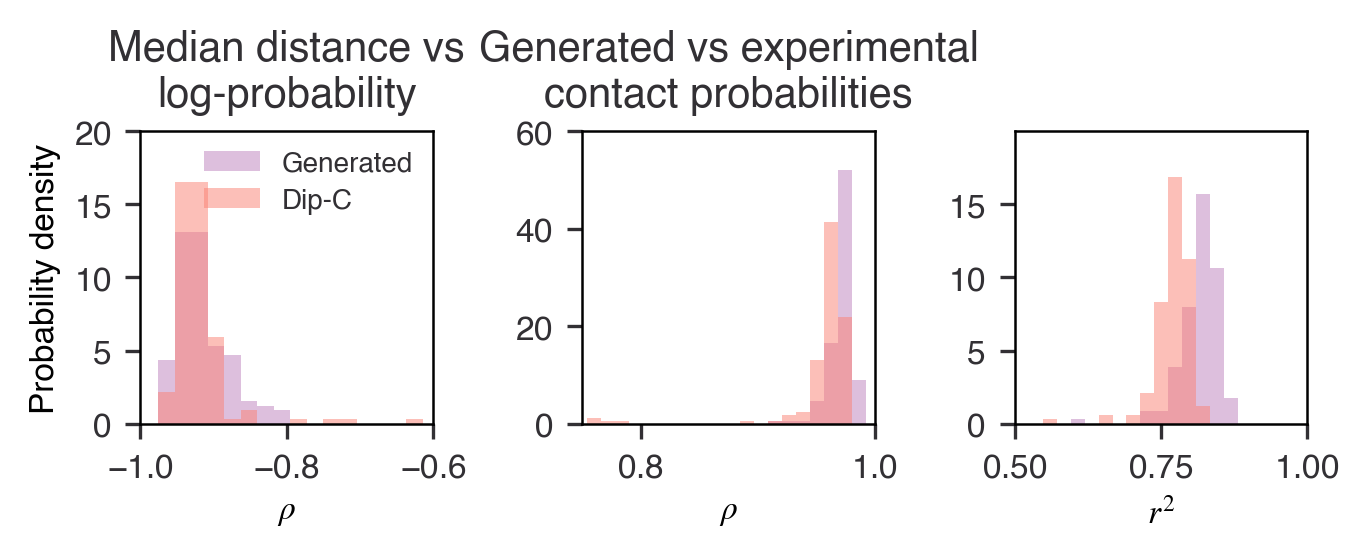

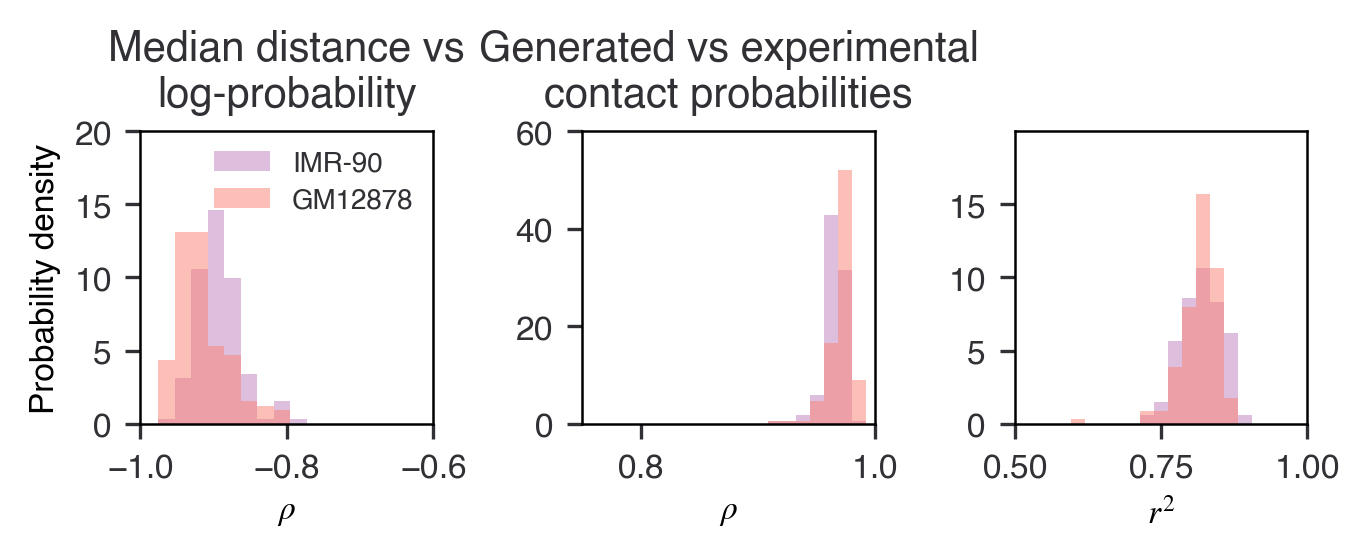

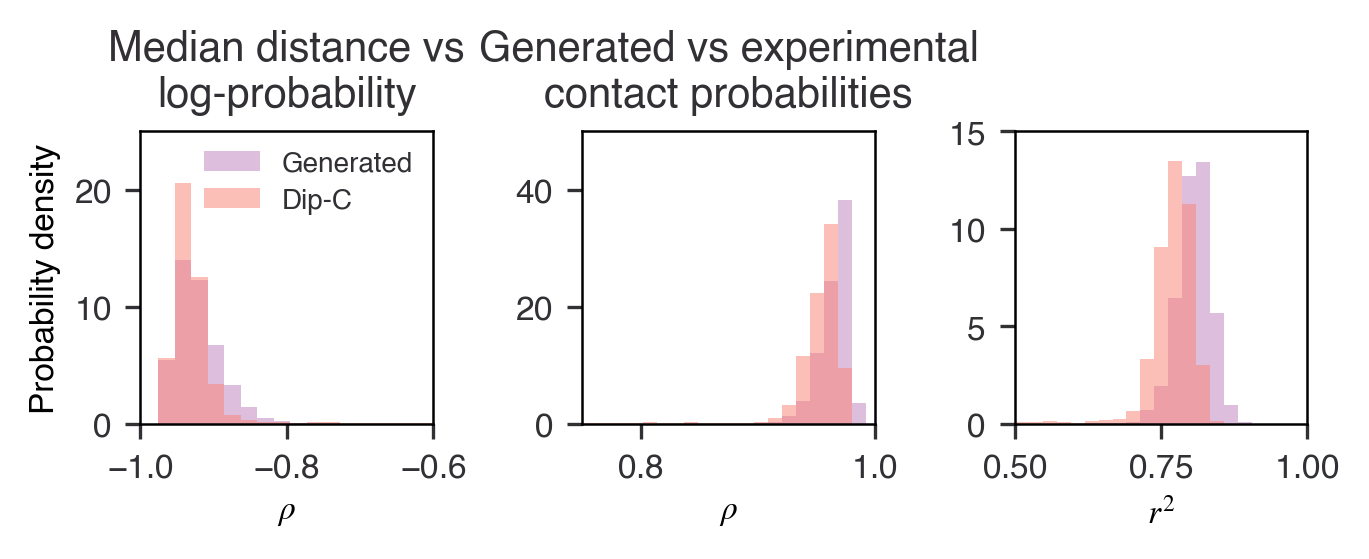

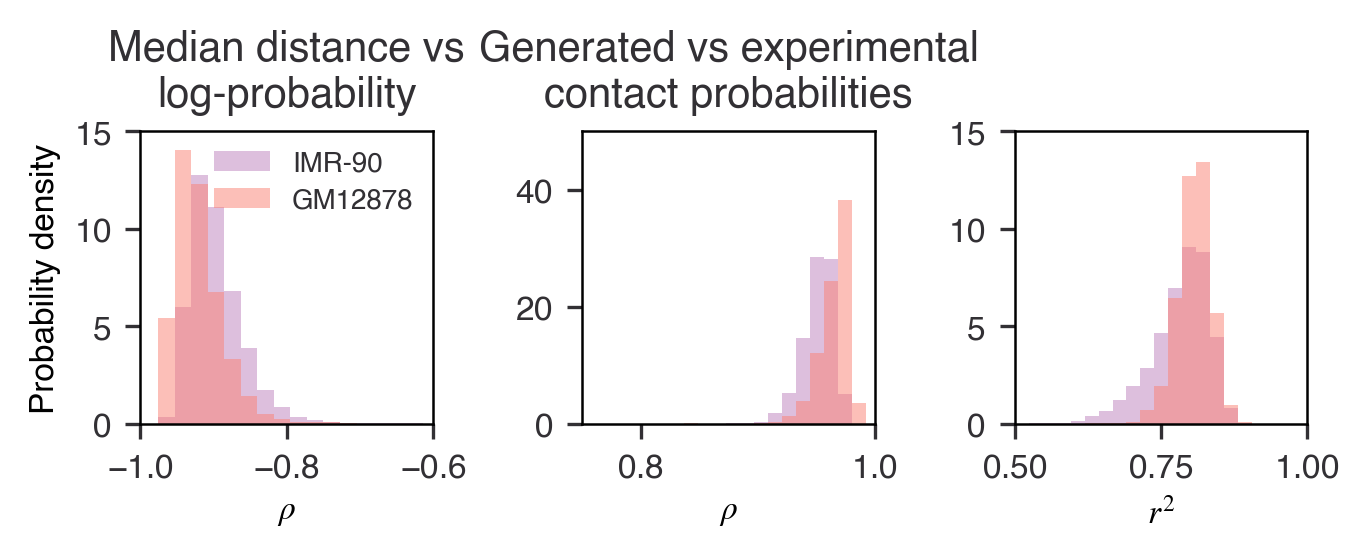

In [36]:
for data_name in ['X','no_X']:

    corr_dist = {}
    r2_prob = {}
    corr_prob = {}
    
    # There are multiple ways to construct the combined generated structure, so bootstrap the median value. 
    # This defines the number of bootstrapping resamplings to perform. 
    n_bootstrap_resamples = 100
    
    # Perform computations on the GPU if possible
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    
    fraction_w1s_to_test = [.5] 
    
    for cell_type,files,exp_hic in [
        ('GM',all_gm_coord_files,gm_hic),
        ('IMR',all_imr_coord_files,imr_hic),
        ('Tan',all_gm_coord_files,gm_hic)
    ]:
    
        data_fp_ = data_fp(cell_type + '_' + data_name)
    
        if os.path.exists(data_fp_):
            temp_data = pickle.load(open(data_fp_,'rb'))
            temp_corr_dist = temp_data['corr_dist']
            temp_r2_prob = temp_data['r2_prob']
            temp_corr_prob = temp_data['corr_prob']
            del temp_data
        else:
            temp_corr_dist = {}
            temp_r2_prob = {}
            temp_corr_prob = {}
    
        # Decide which w=1 vs w=5 fractions to look at
        if cell_type == 'Tan':
            fractions = [0] # Experimental data has no weighting split to consider
        else:
            fractions = fraction_w1s_to_test
    
        # Track whether changes are made such that the data will need to be saved
        modified = False 
        for fraction_w1 in fractions:
            if fraction_w1 in temp_corr_dist:
                continue
    
            modified = True # The data WILL change/need to be saved
            
            gen_median_dists = []
            gen_probs = []
            exp_probs = []
            exp_log_probs = []
    
            for f in tqdm(files):
                
                # Determine the chromosome, region index, and genomic index
                chrom, region_idx, genomic_index = parse_filename(f)
        
                # Load the generated coordinates
                if cell_type == 'Tan':
                    coords1 = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
                else:
                    coords1 = Coordinates(f)
                coords1 = coords1.to(device) 
                inferred_prob_map = conformations_to_probs(coords1)
                    
                coords1.to_(inferred_prob_map.device)
                
                # Load the experimental Hi-C interaction frequencies
                start = genomic_index
                stop = start + resolution * coords1.num_beads
                exp_prob_map = exp_hic.fetch(chrom,start,stop)
        
                # Get the indices for the upper triangle of each set of data, excluding the diagonal
                n = coords1.num_beads
                i,j = torch.triu_indices(n,n,1,device=exp_prob_map.device)
        
                #####
                # Place data into the respective lists
        
                # Interaction frequency
                exp_probs.append(exp_prob_map.prob_map[i,j])
                
                # Remove values associated with NaN Hi-C data
                valid_idx = torch.where(exp_probs[-1].isfinite())[0]
                exp_probs[-1] = exp_probs[-1][valid_idx]
                i,j = i[valid_idx], j[valid_idx]
        
                # Normalize the experimental interaction frequencies to nearest neighbors to
                # obtain contact probabilities consistent with our distance-to-probability 
                # conversion
                exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
                
                # Log probability
                exp_log_probs.append(exp_probs[-1].log10())
                
                # Generated probabilities
                gen_probs.append(inferred_prob_map.prob_map[i,j])
                
                # Interactions with recorded probability 0 become undefined, so remove those points
                valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
                exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
                i,j = i[valid_idx], j[valid_idx]
        
                # Generated distances
                if cell_type != 'Tan':
                    coords1,coords2 = get_gen_coords(f)
                    dists1 = coords1.distances
                    dists2 = coords2.distances
                    dists1._values*= 100
                    dists2._values*= 100
                    n1 = len(dists1)
                    n2 = len(dists2)
                    N = n1 + n2
                    median_dist_resamples = []
                    for _ in range(n_bootstrap_resamples):
        
                        # Decide how many samples to draw from each 
                        # set of conformations
                        nn1 = ( torch.rand(N) < ratio ).sum()
                        nn2 = N - nn1
        
                        # Draw samples to construct new dataset, find median dists, record result
                        median_dist_resamples.append(
                            dists1[torch.randint(n1,(nn1,))].append(
                                dists2[torch.randint(n2,(nn2,))]
                            ).median.values
                        )
                
                    # Record the median of medians
                    gen_median_dists.append(
                        torch.cat(median_dist_resamples,dim=0).median(0).values[i,j]
                    )
                else:
                    gen_median_dists.append(coords1.distances.median.values[0,i,j])
        
            # Compute the desired statistics
            if len(gen_median_dists) > 0:
                cd = batch_corrcoef(gen_median_dists,exp_log_probs).cpu()
                r2p = batch_r2(gen_probs,exp_probs).cpu()
                cp = batch_corrcoef(gen_probs,exp_probs).cpu()
            else:
                cd = []
                r2p = []
                cp = []
    
            del gen_median_dists, exp_log_probs, gen_probs, exp_probs
    
            temp_corr_dist[fraction_w1] = cd
            temp_r2_prob[fraction_w1] = r2p
            temp_corr_prob[fraction_w1] = cp
    
        if modified:
            pickle.dump(
                {
                    'corr_dist':temp_corr_dist,
                    'r2_prob':temp_r2_prob,
                    'corr_prob':temp_corr_prob
                },
                open(data_fp_,'wb')
            )
        
        corr_dist[cell_type] = temp_corr_dist
        r2_prob[cell_type] = temp_r2_prob
        corr_prob[cell_type] = temp_corr_prob
    
    
    # Reformat to what was initially intended
    if 'Tan' in corr_dist:
    
        corr_dist['Tan'] = corr_dist['Tan'][0]
        r2_prob['Tan'] = r2_prob['Tan'][0]
        corr_prob['Tan'] = corr_prob['Tan'][0]
    
    for fraction_w1 in corr_dist['GM']:
        for object in [corr_dist,r2_prob,corr_prob]:
            object[fraction_w1] = {
                'GM':object['GM'][fraction_w1],
                'IMR':object['IMR'][fraction_w1]
            }
    

    ##################################################################################
    # GM12878 plot
    
    fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))
    
    xlabels = [
        '$\\rho$',
        '$\\rho$',
        '$r^2$'
    ]
    titles = [
        'Median distance vs\nlog-probability',
        'Generated vs experimental\ncontact probabilities',
        ''
    ]
    
    # R2-scores
    print(data_name + ': GM12878')
    ratio = .5 
    for i,(r2_GM,r2_tan,bins) in enumerate([(corr_dist[ratio]['GM'],corr_dist['Tan'],all_bins['corr_dist']), 
                                       (corr_prob[ratio]['GM'],corr_prob['Tan'],all_bins['corr_prob']), 
                                       (r2_prob[ratio]['GM'],r2_prob['Tan'],all_bins['r2_prob']) ]):
        ax = axes[i]
        fig,ax = plot_hist(r2_GM,r2_tan,'Generated','Dip-C',fig=fig,ax=ax,bins=bins)
        ax.set_xlabel(xlabels[i])
        ax.set_title(titles[i])
        if i == 0:
            ax.set_xlim([-1,-.6])
            #ax.set_ylabel('Number of\ntested regions')
            ax.set_ylabel('Probability density')
            ax.legend(framealpha=0,loc='upper right',fontsize='small')
        elif i == 1:
            ax.set_xlim([.75,1])
            ax.set_ylim([0,ax.get_ylim()[1]])
        elif i == 2:
            ax.set_xlim([.5,1])
            ax.set_yticks([0,5,10,15],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$'])
    
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
    
        ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )
    
        print(r2_GM.median())
    
    fig.savefig(save_folder+f'HiCCorrelationR2_2_{data_name}.pdf')#,transparent=True)

    ##################################################################################
    # IMR-90 plot
    fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))
    
    xlabels = [
        '$\\rho$',
        '$\\rho$',
        '$r^2$'
    ]
    titles = [
        'Median distance vs\nlog-probability',
        'Generated vs experimental\ncontact probabilities',
        ''
    ]
    
    # R2-scores
    print(data_name + ': IMR-90')
    ratio = .5 
    for i,(r2_IMR,r2_GM,r2_tan,bins) in enumerate([(corr_dist[ratio]['IMR'],corr_dist[ratio]['GM'],corr_dist['Tan'],all_bins['corr_dist']), 
                                       (corr_prob[ratio]['IMR'],corr_prob[ratio]['GM'],corr_prob['Tan'],all_bins['corr_prob']), 
                                       (r2_prob[ratio]['IMR'],r2_prob[ratio]['GM'],r2_prob['Tan'],all_bins['r2_prob'])]):
        ax = axes[i]
        #fig,ax = plot_hist_2(r2_IMR,fig=fig,ax=ax,set_bin_data=torch.cat([r2_GM,r2_tan]))
        fig,ax = plot_hist(r2_IMR,r2_GM,'IMR-90','GM12878',fig=fig,ax=ax,bins=bins)
        ax.set_xlabel(xlabels[i])
        ax.set_title(titles[i])
        if i == 0:
            ax.set_xlim([-1,-.6])
            #ax.set_ylabel('Number of\ntested regions')
            ax.set_ylabel('Probability density')
            ax.legend(framealpha=0,loc='upper right',fontsize='small')
        elif i == 1:
            ax.set_xlim([.75,1])
            ax.set_ylim([0,ax.get_ylim()[1]])
        elif i == 2:
            ax.set_xlim([.5,1])
            ax.set_yticks([0,5,10,15],labels=['$\\mathdefault{0}$','$\\mathdefault{5}$','$\\mathdefault{10}$','$\\mathdefault{15}$'])
    
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
    
        ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )
    
        print(r2_IMR.median())

    fig.savefig(save_folder+f'HiCCorrelationR2_2_{data_name}_IMR.pdf')


### Direct distance comparison

First, get all of the median distance maps & save them in a reversible manner.

Original version

In [37]:
save_file = save_folder + 'median_distances.pkl'

if os.path.exists(save_file):
    all_median_distances = torch.load(save_file)
else:
    tan_data = []
    chromogen_data = []
    key = []
    n_dipc_conformations = []
    for f in tqdm(all_gm_coord_files):

        if '1.0_0.0' not in f: # Avoid double counting due to the mixed data 
            continue

        # Determine the chromosome, region index, and genomic index
        chrom, region_idx, genomic_index = parse_filename(f)

        # Load generated coordinates for both weights being mixed, concatenate them, 
        # convert to distances, and get the median distances. 
        coords1,coords2 = get_gen_coords(f)
        temp_map = coords1.append(coords2).distances.median
        chromogen_data.append(coords1.append(coords2).distances.median)
        del coords1, coords2 
        
        # Fetch the Dip-C structures, convert to distance maps, and get the median values. 
        coords = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
        tan_data.append(coords.distances.median)
        n_dipc_conformations.append(len(coords))
        del coords

        # Log the genomic location for these median distance maps
        key.append( (chrom,region_idx,genomic_index) )

    # Combine all median distance maps, fold them to save space, place in dictionary, and save
    all_median_distances = {
        'ChromoGen':chromogen_data[0].append(chromogen_data[1:]).fold().cpu(),
        'Dip-C':tan_data[0].append(tan_data[1:]).fold().cpu(),
        'Key':key,
        'Number Dip-C conformations':torch.tensor(n_dipc_conformations)
    }
    del chromogen_data, tan_data, key, n_dipc_conformations
    torch.save(all_median_distances,save_file)

To compare many ratios

In [38]:
torch.manual_seed(10) # For reproducibility with the bootstrapping below 

In [39]:
save_file = save_folder + 'median_distances_2.pt'

fraction_w1s = [k/10 for k in range(11)]
num_bootstrapping_steps = 25
    
if os.path.exists(save_file):
    all_median_distances = torch.load(save_file)
else:
    tan_data = []
    chromogen_data = {fraction_w1:[] for fraction_w1 in fraction_w1s}
    key = []
    n_dipc_conformations = []
    for f in tqdm(all_gm_coord_files):

        if '1.0_0.0' not in f: # Avoid double counting due to the mixed data 
            continue

        # Determine the chromosome, region index, and genomic index
        chrom, region_idx, genomic_index = parse_filename(f)

        # Load generated coordinates for both weights being mixed, concatenate them, 
        # convert to distances, and get the median distances. 
        coords1,coords2 = get_gen_coords(f)
        for fraction_w1 in fraction_w1s:
            if fraction_w1 == .5:
                chromogen_data[fraction_w1].append(coords1.append(coords2).distances.median)
            elif fraction_w1 == 0:
                chromogen_data[fraction_w1].append(coords2.distances.median)
            elif fraction_w1 == 1:
                chromogen_data[fraction_w1].append(coords1.distances.median)
            else:
                dists1 = coords1.distances
                dists2 = coords2.distances
                n1 = len(dists1)
                n2 = len(dists2)
                N = n1 + n2
                nn1 = int( N * fraction_w1)
                nn2 = N - nn1
                temp_medians = []
                for _ in range(num_bootstrapping_steps):
                    temp_medians.append( dists1[torch.randperm(n1)[:nn1],...].append(dists2[torch.randperm(n2)[:nn2],...]).median )
                
                chromogen_data[fraction_w1].append(temp_medians[0].append(temp_medians[1:]).median)
        del coords1, coords2 
        
        # Fetch the Dip-C structures, convert to distance maps, and get the median values. 
        coords = Coordinates(config_ds.fetch_specific_coords(chrom,genomic_index)[1])
        tan_data.append(coords.distances.median)
        n_dipc_conformations.append(len(coords))
        del coords

        # Log the genomic location for these median distance maps
        key.append( (chrom,region_idx,genomic_index) )

    # Combine all median distance maps, fold them to save space, place in dictionary, and save
    for fraction_w1 in chromogen_data:
        chromogen_data[fraction_w1] = chromogen_data[fraction_w1][0].append(chromogen_data[fraction_w1][1:]).fold().cpu()
    
    all_median_distances = {
        'ChromoGen':chromogen_data,#chromogen_data[0].append(chromogen_data[1:]).fold().cpu(),
        'Dip-C':tan_data[0].append(tan_data[1:]).fold().cpu(),
        'Key':key,
        'Number Dip-C conformations':torch.tensor(n_dipc_conformations)
    }
    del chromogen_data, tan_data, key, n_dipc_conformations
    torch.save(all_median_distances,save_file)

Now process the data. Don't bother converting to nm since PCC is independent of scales & larger values can introduce numerical issues

In [40]:
'''
for label in ['Dip-C','ChromoGen']:

    # Unfold the maps for easier handling
    all_median_distances[label] = all_median_distances[label].unfold()
'''

all_median_distances['Dip-C'] = all_median_distances['Dip-C'].unfold()
for fraction_w1 in all_median_distances['ChromoGen']:
    all_median_distances['ChromoGen'][fraction_w1] = all_median_distances['ChromoGen'][fraction_w1].unfold()

Now compute all PCC values. Using custom function since torch.corrcoef doesn't accept batches. 

In [42]:
'''
# Get the off-diagonal elements of each median distance map for comparison
n = all_median_distances['Dip-C'].num_beads
i,j = torch.triu_indices(n,n,1)

a = all_median_distances['Dip-C'].values[:,i,j]
b = all_median_distances['ChromoGen'].values[:,i,j]

PCC = ( (a * b).mean(-1) - a.mean(-1) * b.mean(-1) ) / ( a.std(-1) * b.std(-1) )
del a,b
'''
# Get the off-diagonal elements of each median distance map for comparison
n = all_median_distances['Dip-C'].num_beads
i,j = torch.triu_indices(n,n,1)

a = all_median_distances['Dip-C'].values[:,i,j]
PCC = {}
for fraction_w1 in all_median_distances['ChromoGen']:
    b = all_median_distances['ChromoGen'][fraction_w1].values[:,i,j]
    
    PCC[fraction_w1] = ( (a * b).mean(-1) - a.mean(-1) * b.mean(-1) ) / ( a.std(-1) * b.std(-1) )
    del b

Separate the chromosome X data; ignore regions with fewer than min_conformations conformations in the Tan dataset

In [50]:
'''
min_conformations = 80

idx = torch.tensor([i for i,n in enumerate(all_median_distances['Number Dip-C conformations']) if n >= min_conformations])
key = [all_median_distances['Key'][i] for i in idx]
PCCs = {
    'Key':key,
    'All':PCC[idx]
}    
del idx, key 

idx = torch.tensor([ chrom == 'X' for chrom,*_ in PCCs['Key'] ])
PCCs.update({
    'X':PCCs['All'][idx],
    'no_X':PCCs['All'][~idx]
})
del idx
'''

min_conformations = 80

idx = torch.tensor([i for i,n in enumerate(all_median_distances['Number Dip-C conformations']) if n >= min_conformations])
key = [all_median_distances['Key'][i] for i in idx]
PCCs = {
    'Key':key,
    'All':{fraction_w1:PCC[fraction_w1][idx] for fraction_w1 in PCC}
}    
del idx, key 

idx = torch.tensor([ chrom == 'X' for chrom,*_ in PCCs['Key'] ])
idx2 = ~idx
for fraction_w1 in PCC:
    PCCs[fraction_w1] = {
        'All':PCCs['All'][fraction_w1],
        'X':PCCs['All'][fraction_w1][idx],
        'no_X':PCCs['All'][fraction_w1][idx2]
    }

del idx, idx2

##### Plot the values, separating chromosome X since that was excluded from the training data. 

In [51]:
nbins = 50

0.0 All tensor(0.8584, dtype=torch.float64)
0.0 no_X tensor(0.8594, dtype=torch.float64)
0.0 X tensor(0.8335, dtype=torch.float64)

0.1 All tensor(0.8746, dtype=torch.float64)
0.1 no_X tensor(0.8750, dtype=torch.float64)
0.1 X tensor(0.8542, dtype=torch.float64)

0.2 All tensor(0.8878, dtype=torch.float64)
0.2 no_X tensor(0.8888, dtype=torch.float64)
0.2 X tensor(0.8745, dtype=torch.float64)

0.3 All tensor(0.8983, dtype=torch.float64)
0.3 no_X tensor(0.8990, dtype=torch.float64)
0.3 X tensor(0.8872, dtype=torch.float64)

0.4 All tensor(0.9065, dtype=torch.float64)
0.4 no_X tensor(0.9069, dtype=torch.float64)
0.4 X tensor(0.8941, dtype=torch.float64)

0.5 All tensor(0.9127, dtype=torch.float64)
0.5 no_X tensor(0.9134, dtype=torch.float64)
0.5 X tensor(0.9017, dtype=torch.float64)

0.6 All tensor(0.9192, dtype=torch.float64)
0.6 no_X tensor(0.9195, dtype=torch.float64)
0.6 X tensor(0.9101, dtype=torch.float64)

0.7 All tensor(0.9259, dtype=torch.float64)
0.7 no_X tensor(0.9262, dtype=to

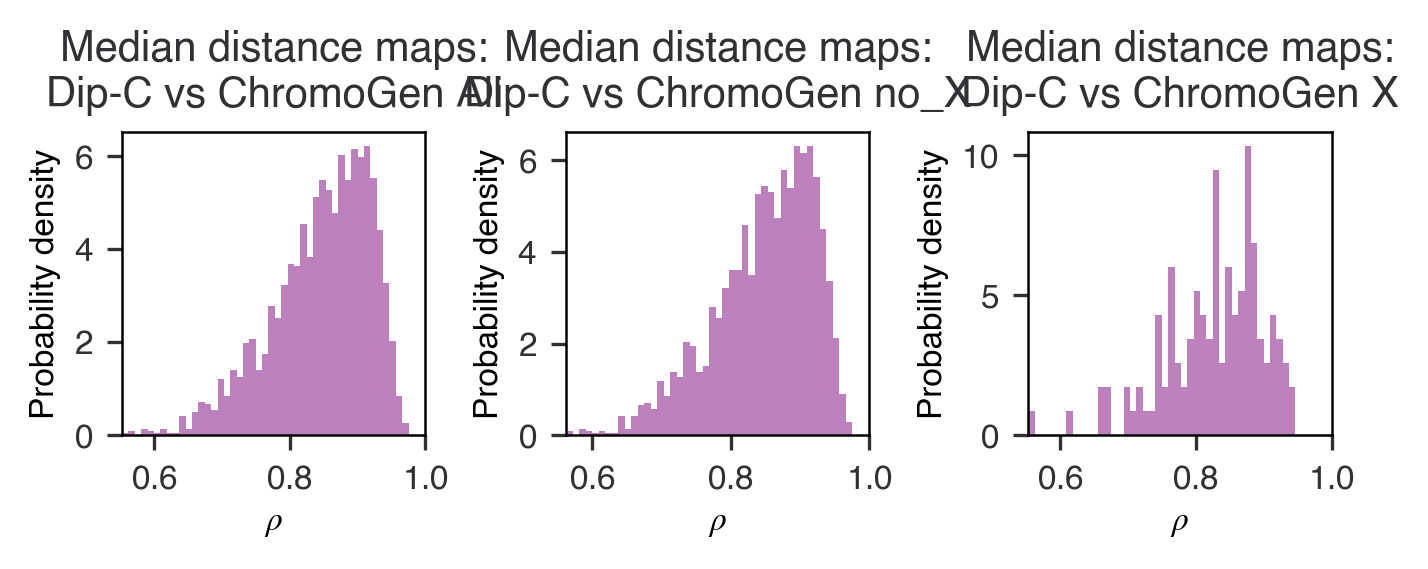

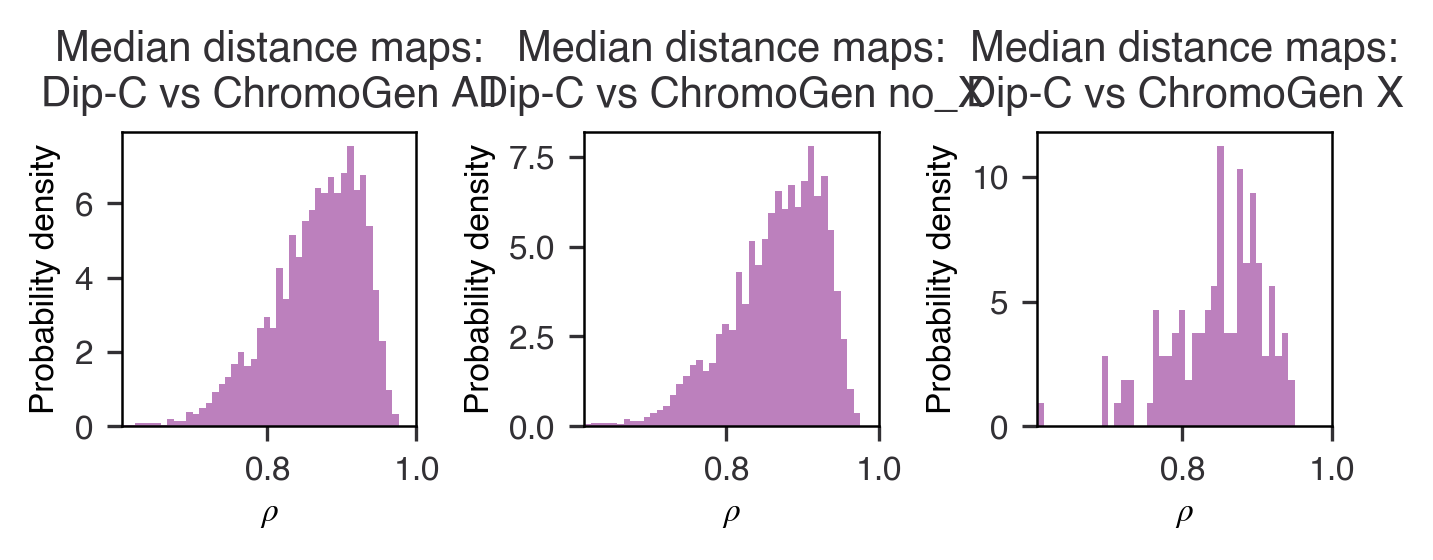

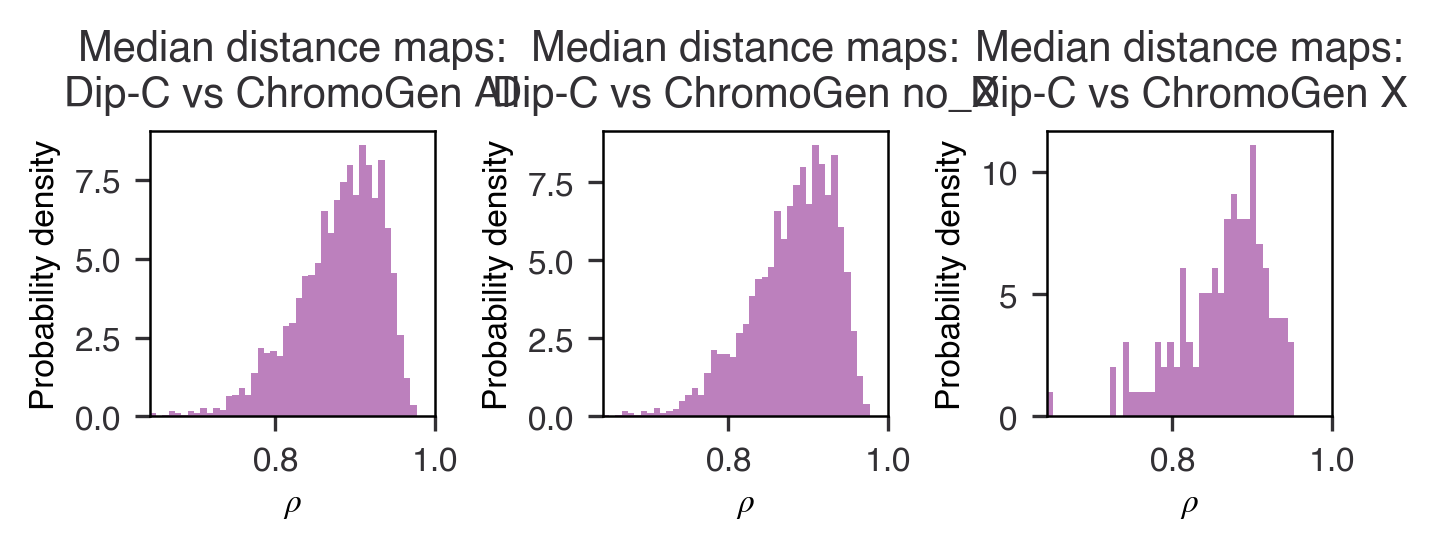

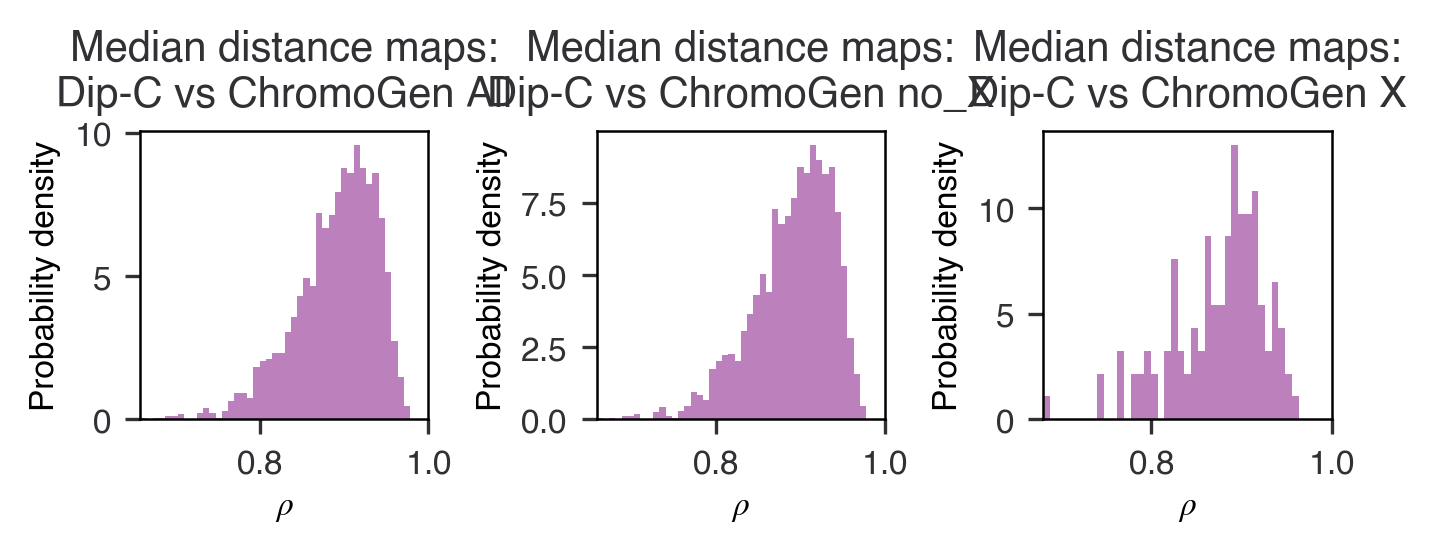

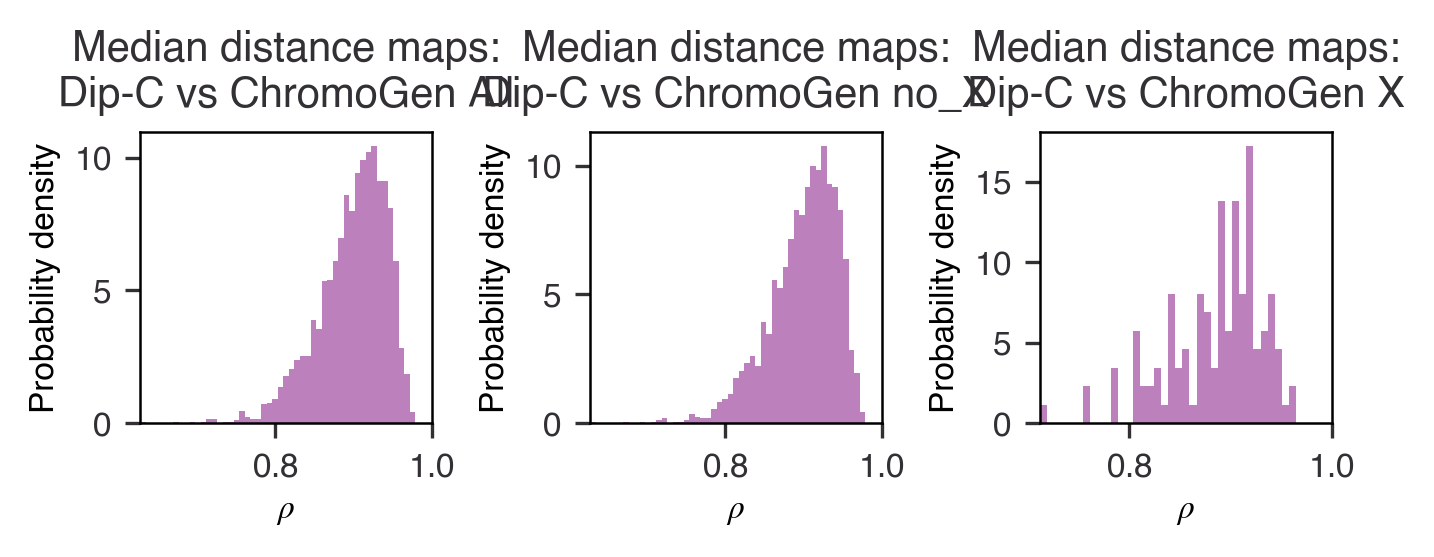

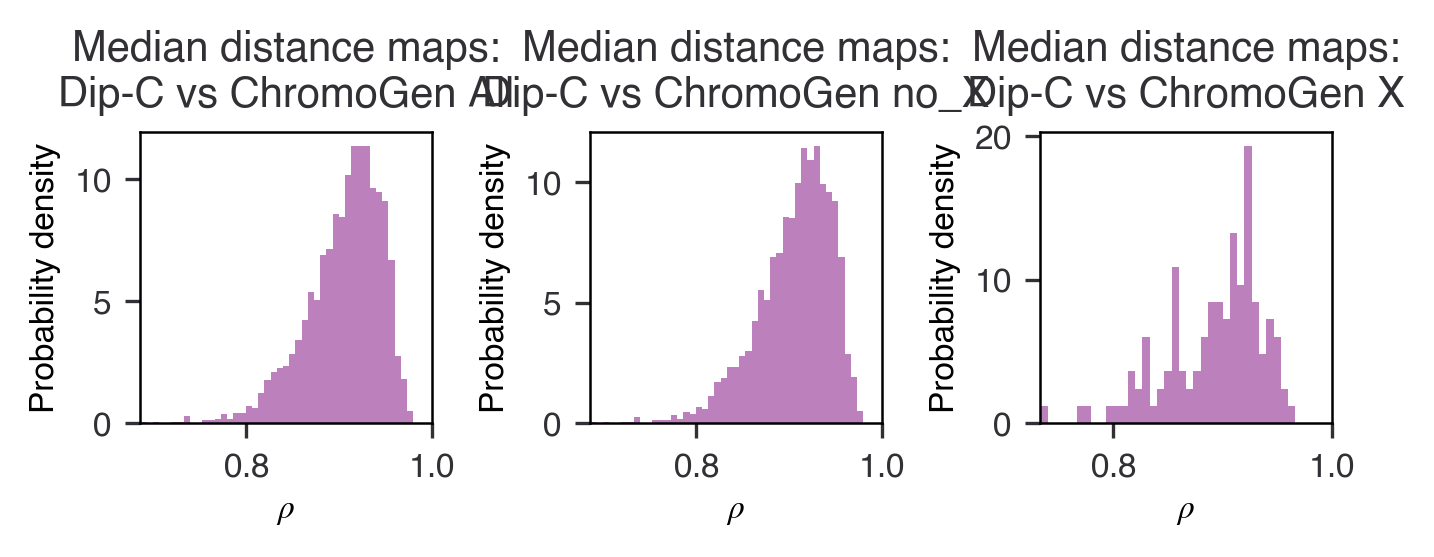

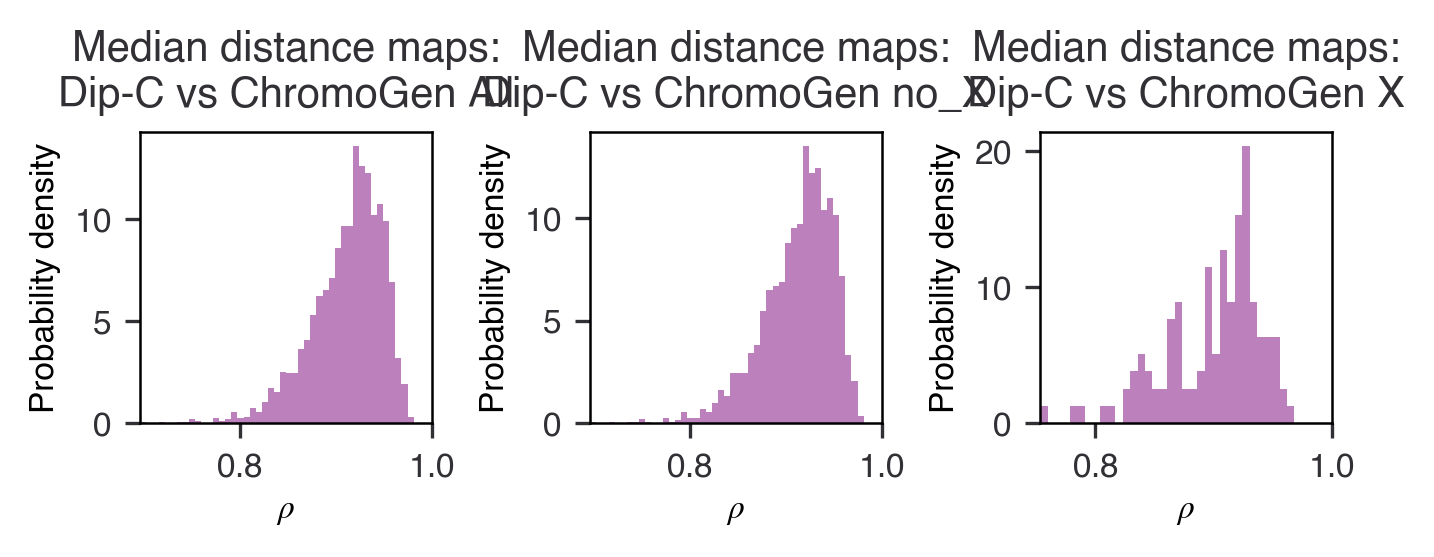

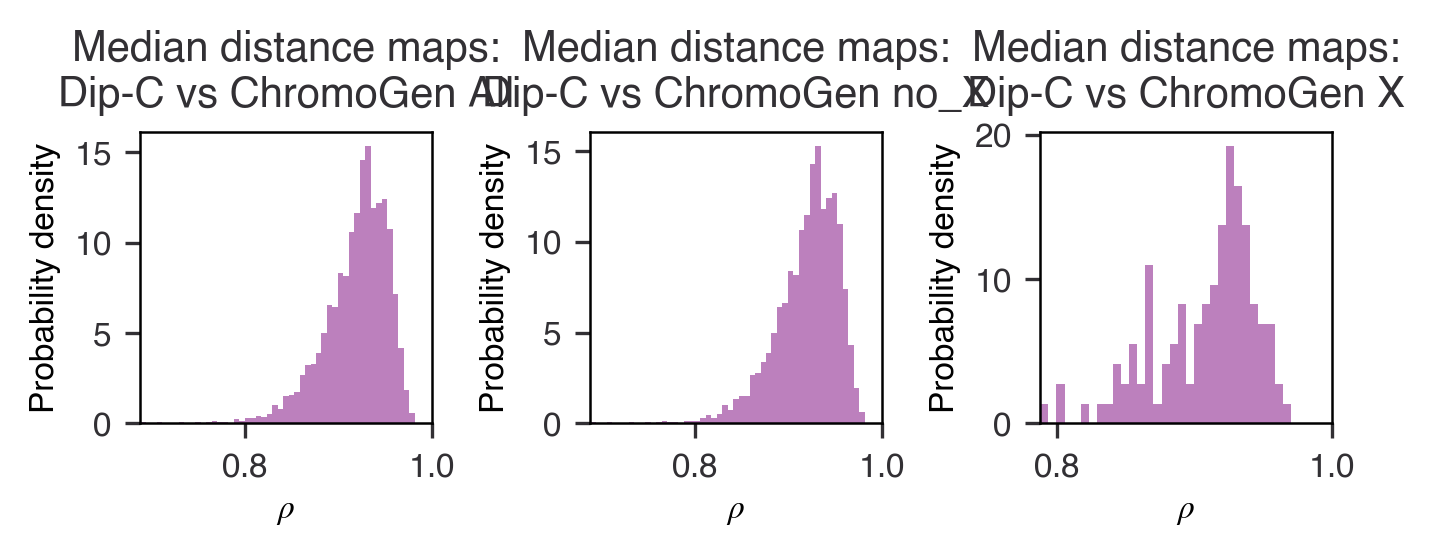

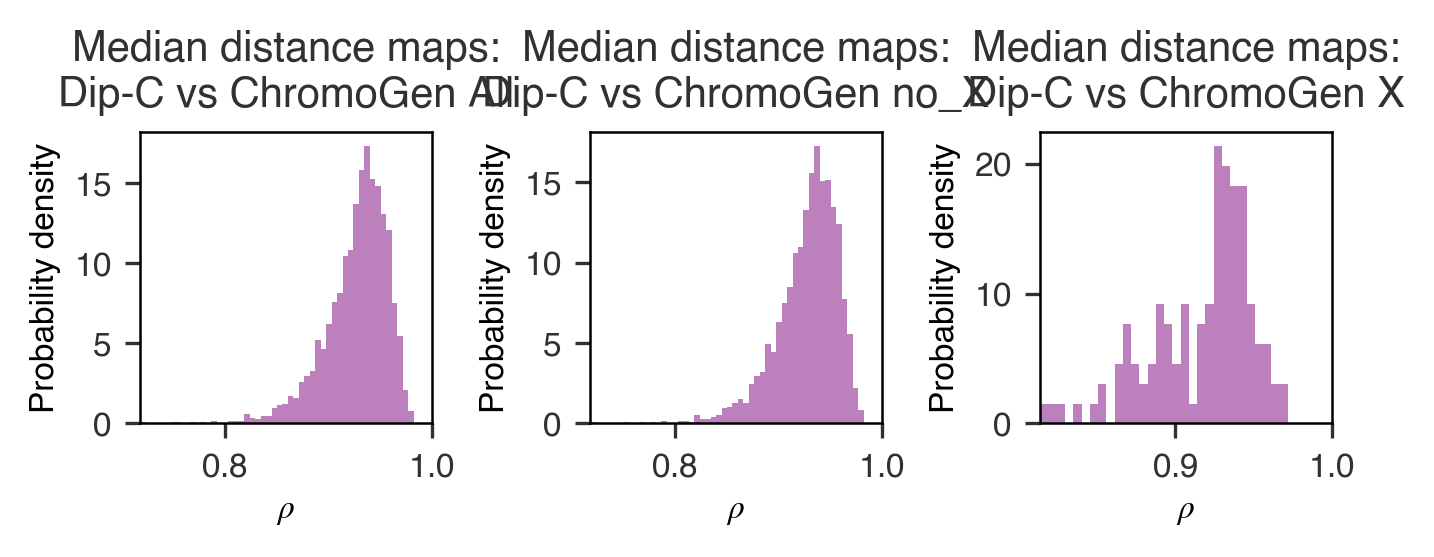

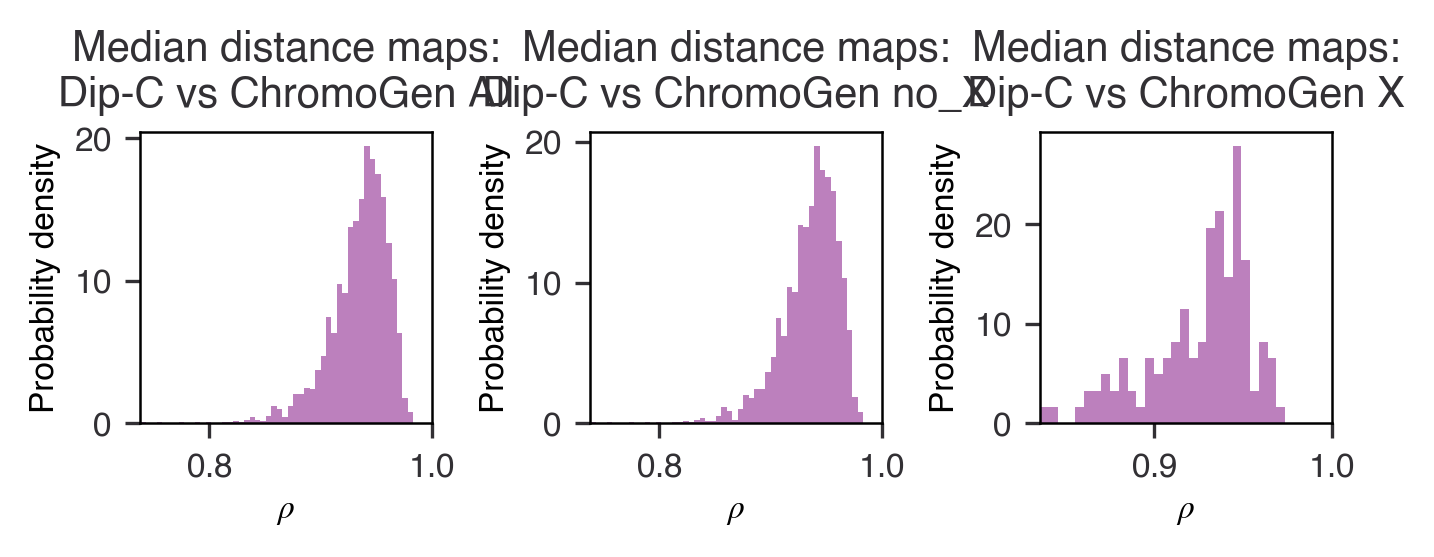

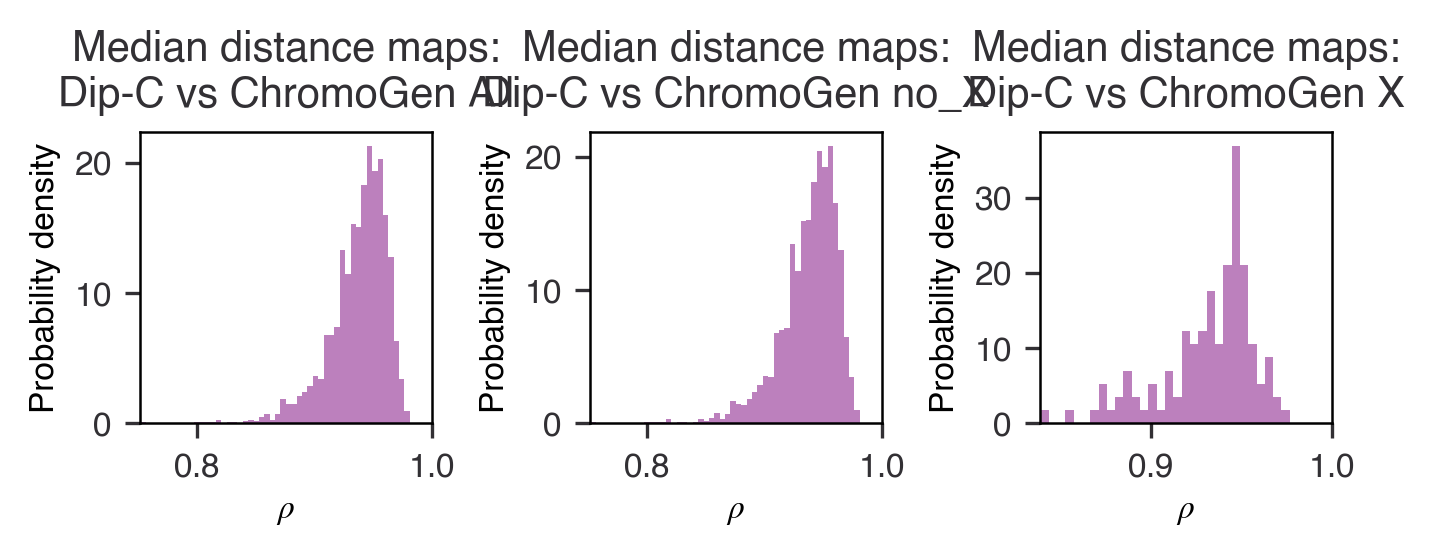

In [54]:
def get_bins(data,nbins=25):
    if type(data) == torch.Tensor:
        data = [data]
    elif type(data) != list or len(list) == 0 or any([ t != torch.Tensor for t in data ]):
        raise Exception('pass torch.Tensor or non-empty list of torch.Tensors')
    
    minn = min([ t.min() for t in data ])
    maxx = max([ t.max() for t in data ])
    delta = (maxx - minn) / nbins

    return torch.arange(minn, maxx+delta/2, delta).cpu()

for fraction_w1 in PCC:
    # Initialize figure
    fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))
    
    # Get the bins we want to use to maintain consistency
    bins = get_bins(PCCs[fraction_w1]['All'],nbins).numpy()
    
    # Create the plots
    test=[]
    for k,data_name in enumerate(['All','no_X','X']):
    
        # Fetch the correct data, axis, etc.
        data = PCCs[fraction_w1][data_name]
        ax = axes[k]
    
        # Plot the data
        densities,*_ = ax.hist(data.flatten().cpu().numpy(),bins=bins,density=True,edgecolor='none',alpha=1)
    
        # Set labels
        # Include data_name in title avoid mistakes later. Can remove in Illustrator
        ax.set_title('Median distance maps:\nDip-C vs ChromoGen '+data_name)
        ax.set_xlabel('$\\rho$')
        ax.set_ylabel('Probability density')
    
        # Zoom in on the data for better visualization
        i = 0
        while densities[i] == 0:
            i+=1
        xlims = [ bins[i] ,1]
        ylims = [0, densities.max() * 1.05]
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        
        # Ensure the axis is square
        ax.set_aspect( (xlims[1]-xlims[0])/(ylims[1]-ylims[0]) )
        test.append( (densities,i) )
        del i, xlims, ylims
    
        # Print the median for the main text 
        print(fraction_w1,data_name,data.median())
        
        # Save figure
        #fig.savefig(save_folder+f'dist_vs_dist_correlation_{fraction_w1}.pdf')
    print('')


##### For the SI, show best, worst, medium agreement

In [ ]:
temp = PCCs['All'].clone()

ncols = 6

fig,axes = plt.subplots(nrows=3,ncols=ncols,figsize=(7.08661,6.69291),layout='constrained')

for i in range(3):
    for j in range(ncols//2):

        # Identify the relevant index
        if i == 0:
            k = torch.where( temp==temp[temp.isfinite()].min() )[0][0]
        elif i == 1:
            k = torch.where( temp==temp[temp.isfinite()].median() )[0][0]
        else:
            k = torch.where( temp==temp[temp.isfinite()].max() )[0][0]
        rho = temp[k].tolist()
        temp[k] = torch.nan

        # Genomic data
        info = PCCs['Key'][k]

        ##################################
        # Load, plot the experimental Hi-C
        hic_map = gm_hic.fetch(info[0],info[-1],info[-1]+1_280_000)
        ax = axes[i][2*j]
        fig,ax,im,cbar = hic_map.plot(fig=fig,ax=ax,cbar_orientation='horizontal',vmax=1)

        if i == 2:
            cbar.set_label('Interaction frequency')
        else:
            cbar.set_label('')
        ax.set_ylabel('Genomic index' if j==0 else '')
        start = round(info[-1]/1e6,3)
        stop = round(start + 1.28,3)
        ax.set_title(
            f'Chromosome {info[0]}:' + 
            '\n' + 
            f'{start}-{stop} Mb'
        )

        #cbar_ticks = cbar.get_ticks()
        #if 1 not in cbar_ticks:
        #    cbar.set_ticks([*cbar_ticks,1])
        #    cbar.ax.set_xlim([cbar.ax.get_xlim()[0],1])

        ##################################
        # Get and plot the distance maps 

        # Find the corresponding index in the all_median_distances dict
        # so we can get the proper median distance maps
        k=0
        while all_median_distances['Key'][k] != info:
            k+=1
        
        ax = axes[i][2*j+1]

        gen = all_median_distances['ChromoGen'][k].float().clone()
        tan = all_median_distances['Dip-C'][k].float().clone()
        gen._values*= 100
        tan._values*= 100

        fig,ax,im,cbar = tan.plot_with(gen,fig=fig,ax=ax,cbar_orientation='horizontal')
        ax.set_title('$\\rho=' + f'{round(rho,4)}' + '$')
        ax.set_ylabel('')
        if i == 2:
            cbar.set_label('Distance (nm)')
        else:
            cbar.set_label('')
        
# Save the figure 
fig.savefig(save_folder + 'best_median_worst_distance_agreement.pdf')


In [32]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
#for i,
#r2_dist['GM']
(corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) 
for i,f in enumerate(all_gm_coord_files):

    if 'sample_395_5.0_8.0_120_1.pt' in f:
        print(corr_dist['GM'][i],corr_prob['GM'][i], r2_prob['GM'][i])
    

In [ ]:
for i,(r2_IMR,r2_GM) in enumerate([ (corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) ]):

    print(r2_GM.median())
    

In [ ]:
torch.corrcoef(
    torch.stack([gen_median_dists[0],exp_log_probs[0]],dim=0)
)

In [ ]:
exp_prob_map.plot()

In [ ]:
plt.plot(gen_median_dists[-1],exp_probs[-1][valid_idx],'.')#10**exp_log_probs[0],'.')
plt.yscale('log')

In [ ]:
n = 54

f = all_gm_coord_files[n]
chrom, region_idx, genomic_index = parse_filename(f)
start = genomic_index
stop = start + resolution * 64

i,j = torch.triu_indices(64,64,1)

plt.plot(
    Coordinates(f).distances.median.values[0,i,j],
    gm_hic.fetch(chrom,start,stop).prob_map[i,j],
    '.'
)
plt.yscale('log')

In [ ]:
y = gm_hic.fetch(chrom,start,stop).prob_map[i,j].log10()
x = Coordinates(f).distances.median.values[0,i,j][y.isfinite()]
y = y[y.isfinite()]


torch.corrcoef( 
    torch.stack(
        [
            x,
            y
        ],
        dim=0
    )
)

In [ ]:
plot_region(all_gm_coord_files[90],gm_hic)

#### Scatter plot + R-squared values

In [ ]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]

In [ ]:
def parse_filename(f):
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [ ]:
def get_gen_hic(fp,r_c=1.5,sigma=3.72):

    if type(fp) == torch.Tensor:
        p = fp.clone()
    elif type(fp) == str:
        p = Coordinates(fp).distances.values
    else:
        p=fp.distances.values
        
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)

    return p
    return HiCMap(p)

In [ ]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals = []
r_c_vals = []
sigma_vals = []
hic_corrcoefs = []

r_c_unique = torch.tensor([2.])#torch.arange(1.9,2.1,.02)
sigma_unique = torch.tensor([2.]) #torch.arange(1.,6.1,.25)

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

with tqdm(initial=0,total=len(r_c_unique)*len(sigma_unique)*n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j]
            exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            coords = Coordinates(d+f).distances.values[...,i,j]
    
            for r_c in r_c_unique:
                for sigma in sigma_unique:
            
                    gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
                    #gen_probs = gen_map.prob_map[i,j]
                    gen_probs = gen_map 
                    
                    #idx = torch.where(exp_probs.isfinite())[0]
                    r2_vals.append(r2_score(gen_probs[idx],exp_probs))

                    hic_corrcoefs.append(
                        torch.corrcoef(
                            torch.stack([gen_probs[idx],exp_probs],dim=0)
                        )[0,1]
                    )
                    
                    r_c_vals.append(r_c)
                    sigma_vals.append(sigma)
                    pbar.update(1)
'''
for r_c in torch.arange(1,2.1,.1):
    for sigma in torch.arange(3.,4.1,.1):
        for d in gm_directories:
            files = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
            for f in files:
                chrom,region_idx,start = parse_filename(f)
                
                exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
                exp_probs = exp_map.prob_map[i,j]
                exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
                
                gen_map = get_gen_hic(d+f,r_c=r_c,sigma=sigma)
                gen_probs = gen_map.prob_map[i,j]
                
                idx = torch.where(exp_probs.isfinite())[0]
                r2_vals.append(r2_score(gen_probs[idx],exp_probs[idx]))
                
                r_c_vals.append(r_c)
                sigma_vals.append(sigma)
'''
r_c_vals = torch.tensor(r_c_vals)
sigma_vals = torch.tensor(sigma_vals)
r2_vals = torch.tensor(r2_vals)
hic_corrcoefs = torch.tensor(hic_corrcoefs)

In [ ]:
plt.hist(hic_corrcoefs.numpy())#,density=True)
plt.xlabel('PCC between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.title('Analyzing match between experimental and inferred Hi-C')

In [ ]:
plt.hist(r2_vals.numpy())#,density=True)
plt.xlabel('$r^2$ between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.ylabel('Analyzing match between experimental and inferred Hi-C')

In [ ]:
plt.hist(torch.tensor(r2_vals).numpy())

In [ ]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals_spatial = []
corrcoefs = []

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

all_dists = []
all_probs = []
with tqdm(initial=0,total=n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            mean_dists = Coordinates(d+f).distances.mean.values[0,i,j] * 100

            #gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
            #gen_probs = gen_map.prob_map[i,j]
            #gen_probs = gen_map 
            
            #idx = torch.where(exp_probs.isfinite())[0]
            r2_vals_spatial.append(r2_score(mean_dists[idx],exp_probs))
            corrcoefs.append( torch.corrcoef(torch.stack([mean_dists[idx],exp_probs],dim=0))[0,1] )

            all_dists.append(mean_dists[idx])
            all_probs.append(exp_probs)

            pbar.update(1)
r2_vals_spatial = torch.tensor(r2_vals_spatial)
corrcoefs = torch.tensor(corrcoefs)
all_dists = torch.cat(all_dists)
all_probs = torch.cat(all_probs)

In [ ]:
plt.hist(corrcoefs)
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Number of regions')
plt.title('Correlation between mean distance and experimental contact probability')

In [ ]:
import numpy as np

#m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)
m,b = np.polyfit(all_dists.log10().cpu().numpy(),all_probs.cpu().numpy(),1)

#x = [mean_dists[idx].min(),mean_dists[idx].max()]
x = [all_dists.min(),all_dists.max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

#plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(all_dists.cpu().numpy(),(10**all_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()

In [ ]:
torch.where( corrcoefs==corrcoefs.min() )

In [ ]:
i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]

n=0
ii=72
for d in files:
    for f in files[d]:
        if n == ii:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            exp_probs = exp_probs[idx]
            
            mean_dists = (Coordinates(d+f).distances.mean.values[0,i,j] * 100)
        n+=1
        if n > ii:
            break
    if n > ii:
        break
            
import numpy as np

m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)

x = [mean_dists[idx].min(),mean_dists[idx].max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()

Compare many milestones!

In [ ]:
a = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.5_0.1_120_1.pt')
a.distances.mean.plot()

In [ ]:
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
fp = lambda w,phi: folder + f'sample_395_{float(w)}_{float(phi)}_120_1.pt'

all_coor
for guidance in [k/2 for k in range(3,11)]:
    for phi in [k/10 for k in range(100)]:
        f = fp(guidance,phi)
        if os.path.exists(f):
            

conformations_to_probs(a).plot()

In [ ]:
conformations_to_probs(a).plot()

In [ ]:
coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.5_0.1_120_1.pt')
coords = coords.append(
    [
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/sample_395_5.0_8.0_120_1.pt')[:1000],
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_2.0_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_2.5_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_3.0_0.3_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_3.5_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_4.0_0.5_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_4.5_0.1_120_1.pt'),
    ]
)

In [ ]:
coords.distances.median.plot()

In [ ]:
i,j = torch.triu_indices(64,64,1)

a = coords.distances
b = a.median.values[0,i,j]
a = a.mean.values[0,i,j]

plt.plot(a,b,'.')
plt.xlabel('Mean distance')
plt.ylabel('Median distance')


In [ ]:
conformations_to_probs(coords).plot()

In [ ]:
coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.0_0.0_120_1.pt')
coords.distances.median.plot()
conformations_to_probs(coords).plot()

In [ ]:
coords.distances.median.plot(vmin=2,vmax=6)

In [ ]:
rosetta = pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')

In [ ]:
def conformations_to_probs(conformations,sigma=sigma,r_c=r_c):
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)
    return HiCMap(p)

In [ ]:
def conformations_to_probs(conformations,sigma=6,r_c=.5):
    p = conformations.distances.values.clone()
    
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**3.45 / 2
    p = p.mean(0)
    '''
    mask = p < (2 ** (1/3) * r_c)
    p[mask] = 1
    mask^= True
    p[mask] = (r_c/p[mask])**3.45
    p = p.mean(0)
    '''
    return HiCMap(p)

In [ ]:
chrom = '1'
region_idx = 395
'''
cond_scale = 2.0
rescaled_phi = 0.1
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
'''
cond_scale = 5.0
rescaled_phi = 8.0
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/'

coords = Coordinates(
    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
)

#####
# Median distance map
d = coords.distances.median
d._values*= 100 # to nm
d.plot()

#####
# Hi-C 

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
#exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Plot against generated Hi-C 
exp_map.plot_with(conformations_to_probs(coords))

In [ ]:
chrom = '1'
region_idx = 395
'''
cond_scale = 1#2.0
rescaled_phi = 0#0.1
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
'''
cond_scale = 5.0
rescaled_phi = 8.0
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/'

r_c = 1.5
sigma = 3.72

coords = Coordinates(
    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
)

#####
# Median distance map
d = coords.distances.median
d._values*= 100 # to nm
d.plot()

#####
# Hi-C 

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Plot against generated Hi-C 
_,ax,*_=exp_map.plot_with(conformations_to_probs(coords,sigma=10,r_c=1.5))

i,j = torch.triu_indices(64,64,1)

x = exp_map.prob_map[i,j]
y = conformations_to_probs(coords,sigma=sigma,r_c=r_c).prob_map[i,j]
ax.set_title(
    '$\\rho='+f'{torch.corrcoef(torch.stack([x,y],dim=0))[0,1]}$'+'\n'+\
    '$\\sigma='+ f'{sigma}'+'$; $r_c=' + f'{r_c}' + '$'
)
#ax.set_title(
#    '$\\rho='+f'{torch.corrcoef(torch.stack([x,y],dim=0))[0,1]}$'+'\n'+\
#    'Power law only: $r_c=' + f'{r_c}' + '$'
#)


#### Combine probabilities!

In [ ]:
from Distances import Distances

In [ ]:
chrom = '1'
region_idx = 395

combos = [
    (1,0,'../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'),
    #(.5,0,'../data/samples/origami_64_no_embed_reduction/pt_files/'),
    (5,8,'../data/samples/origami_64_no_embed_reduction/eval_mode/')
]

# To index upper triangle
i,j = torch.triu_indices(64,64,1)

# Target probabilities
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()
target = exp_map.prob_map[i,j]

# Experimental probabilities, to combine
all_probs = []
all_coords = []
for cond_scale,rescaled_phi,folder in combos:

    f = folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
    if cond_scale >= 1:
        coords = Coordinates(f)
    else:
        coords = Distances(torch.load(f)).unfold().unnormalize().coordinates

    all_coords.append(coords)
    
    all_probs.append(
        conformations_to_probs(
            coords,
            sigma=sigma,
            r_c=r_c
        ).prob_map[i,j]
    )

scores = []
lin_scales = torch.arange(0,1.001,.001)
for c in lin_scales:
    temp_probs = all_probs[0] * c + all_probs[1] * (1-c)
    scores.append(
        torch.corrcoef(torch.stack([temp_probs,target],dim=0))[0,1]
        #r2_score(temp_probs,target)
    )

scores = torch.tensor(scores)
idx = torch.where(scores==scores.max())

best_lin_scale = lin_scales[idx]

######
# Plot

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Combine data

all_probs = []
for k,(cond_scale,rescaled_phi,folder) in enumerate(combos):
    temp_map = conformations_to_probs(
        all_coords[k],
        #Coordinates(
        #    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
        #),
        sigma=sigma,
        r_c=r_c
    )
    all_probs.append(temp_map)
    if k == 0:
        gen_map = temp_map
        median_dists = all_coords[k].distances.mean
    else:
        gen_map.prob_map*= best_lin_scale
        gen_map.prob_map+= temp_map.prob_map * (1-best_lin_scale)
        median_dists._values*= best_lin_scale
        median_dists._values+= all_coords[k].distances.mean.values*(1-best_lin_scale)
        median_dists._values*= 100

median_dists.plot(vmin=150,vmax=800)

# Plot against generated Hi-C 
_,ax,*_=exp_map.plot_with(gen_map)

#i,j = torch.triu_indices(64,64,1)

#x = exp_map.prob_map[i,j]
#y = conformations_to_probs(coords,sigma=sigma,r_c=r_c).prob_map[i,j]
ax.set_title(
    '$\\rho='+f'{scores.max()}$'+'\n'+\
    '$\\sigma='+ f'{sigma}'+'$; $r_c=' + f'{r_c}$, $w=1$ influence: {float(best_lin_scale):.3}'
)

In [ ]:
median_dists.plot(vmin=150,vmax=800)

In [ ]:
a=Coordinates(
    '../data/samples/origami_64_no_embed_reduction/eval_mode/sample_395_5.0_8.0_120_1.pt'
).distances.median
a._values*= 100
a.plot(vmin=None,vmax=None,cmap='viridis')
a.plot(vmin=150,vmax=800)

a._values*=-1
a.plot(vmin=-800,vmax=-150,cmap='seismic')

In [ ]:
i,j = torch.triu_indices(64,64,1)
x = exp_map.prob_map[i,j]
y = conformations_to_probs(coords,sigma=3,r_c=1.5).prob_map[i,j]

plt.plot(x,y,'.')
plt.xlabel('Experimental Hi-C')
plt.ylabel('Generated Hi-C')
torch.corrcoef(torch.stack([x,y],dim=0))

### Try optimizing this stuff!

In [ ]:
from tqdm.auto import tqdm
def get_sample_probs(
    energy
):
    sample_energies = -energy
    sample_energies = sample_energies - sample_energies.max()
    log_Z = torch.logsumexp(sample_energies,(0,1))
    sample_prob = (sample_energies - log_Z).exp()
    return sample_prob

def optimize_hic(fp1,num_iterations=1000,lr=.1,lr_decay=0):

    # Get second filepath 
    fp2 = data_dir2 + fp1.split('/')[-1]
    fp2 = fp2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    fp2 = fp2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))

    # Load the generated conformations at both weights
    all_coords = Coordinates(fp1).append(
        Coordinates(fp2)
    )
    
    # Get the associated probabilities associated with each conformation
    all_probs1 = conformations_to_probs(all_coords,average=False)

    # Take the upper triangle (minus nearest neighbors) for optimization
    n = all_coords.num_beads
    i,j = torch.triu_indices(n,n,2)
    all_probs = all_probs1[:,i,j]

    # Get the normalized Hi-C to make comparisons
    chrom,_,start = parse_filename(fp1)
    stop = start + 1_280_000
    exp_map = gm_hic.fetch(chrom,start,stop)
    exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(n-1),range(1,n)])
    target = exp_map.prob_map[i,j]

    # Remove any nan values from both generated and experimental probabilities
    idx = torch.where(target.isfinite())[0]
    all_probs = all_probs[:,idx]
    target = target[idx]
    del idx

    # Define the energies
    energy = torch.zeros_like(all_probs[:,:1]).requires_grad_(True)
    #energy.requires_grad_(True)
    
    # Prepare for the optimization
    optimizer = torch.optim.Adagrad(
        [energy],
        lr=lr,
        lr_decay=lr_decay
    )


    with tqdm(initial=0,total=num_iterations) as pbar:
        for k in range(num_iterations):

            optimizer.zero_grad()
            weights = get_sample_probs(energy)
            mean_probs = (weights * all_probs).mean(0)
            loss = (mean_probs - target).square().sum() + energy.std()
            loss.backward()
            optimizer.step()
            if k == 0 or k % 10 == 0:
                pbar.set_description(f'loss: {loss.item()}')
            if (k+1) % 10 == 0:
                pbar.update(10)


    final_weights = get_sample_probs(energy.detach()).unsqueeze(-1)
    final_weighted_hic = HiCMap( (all_probs1 * final_weights).sum(0) )
    
    return all_coords,final_weights,final_weighted_hic,exp_map, all_probs
    

    
    

In [ ]:
all_coords,weights,opt_hic,exp_map, all_probs = optimize_hic(
    all_gm_coord_files[65],num_iterations=25_000,lr=.01
)

_,ax,*_=exp_map.plot_with(opt_hic)
ax.set_title('Optimized Weights')

In [ ]:
w = weights.flatten()
set_idx = torch.where(w > w.median())[0]
_,ax,*_ = exp_map.plot_with(
    conformations_to_probs(
        all_coords[set_idx]
    )
)
ax.set_title('Optimized selection:\n'+\
             f'{(set_idx>=1000).sum()} conformations with w=4')

In [ ]:
ii = torch.where(w>=w.median())[0]
len(ii), (ii < 1000).sum()

In [ ]:
plt.plot(weights.flatten().sort().values.numpy())

In [ ]:
f1 = all_gm_coord_files[65]
ratios = [1.,.2,.5,.8,0.]

#fig,axes = plt.subplots(nrows=1,ncols=5,figsize=(2,12))

chrom,_,start = parse_filename(f1)
stop = start + 1_280_000
exp_map = gm_hic.fetch(chrom,start,stop)
exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(63),range(1,64)])

i,j = torch.triu_indices(64,64,1)
for k,ratio in enumerate(ratios):
    temp = get_gen_data(f1,ratio=ratio)[0]
    _,ax,*_=exp_map.plot_with(
        temp#,fig=fig,ax=axes[k]
    )
    ax.set_title(f'Fraction from $w=1$: {ratio}')

    print(ratio,temp.prob_map[i,j].std())
    


In [ ]:
w1_stds = []
w4_stds = []
w1_covs = []
w4_covs = []
i,j = torch.triu_indices(64,64,1)
for f1 in all_gm_coord_files:

    chrom,_,start = parse_filename(f1)
    exp_probs = gm_hic.fetch(chrom,start,start+1_280_000).prob_map
    exp_probs/= torch.nanmean(exp_probs[range(63),range(1,64)])
    exp_probs = exp_probs[i,j]
    idx = torch.where(exp_probs.isfinite())[0]
    exp_probs = exp_probs[idx]
    exp_mean = exp_probs.mean()

    f2 = data_dir2 + f1.split('/')[-1]
    f2 = f2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    f2 = f2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    

    for f,std_list,cov_list in [(f1,w1_stds,w1_covs),(f2,w4_stds,w4_covs)]:
    
        probs =  conformations_to_probs(Coordinates(f))[i,j][idx]
        p_mean = probs.mean()
        p_mean_sq = (probs**2).mean()

        std_list.append( p_mean_sq - p_mean**2 )
        cov_list.append( (probs*exp_probs).mean() - p_mean * exp_mean)

    '''
    w1_stds.append(
        conformations_to_probs(
            coords1
        ).prob_map[i,j].std()
    )
    w

    f2 = data_dir2 + f1.split('/')[-1]
    f2 = f2.replace(str(float(cond_scale1)),str(float(cond_scale2)))
    f2 = f2.replace(str(float(rescaled_phi1)),str(float(rescaled_phi2)))
    
    w4_stds.append(
        conformations_to_probs(
            Coordinates(f2)
        ).prob_map[i,j].std()
    )
    '''

w1_stds = torch.tensor(w1_stds)
w4_stds = torch.tensor(w4_stds)
w1_covs = torch.tensor(w1_covs)
w4_covs = torch.tensor(w4_covs)

In [ ]:
minn = min(w1_stds.min(),w4_stds.min())
maxx = max(w1_stds.max(),w4_stds.max())
delta = (maxx-minn)/25
bins = torch.arange(minn,maxx+delta/2,delta).numpy()

plt.hist(w1_stds.flatten().numpy(),label=f'w=1, median={w1_stds.median()}',bins=bins,alpha=.5)
plt.hist(w4_stds.flatten().numpy(),label=f'w=4, median={w4_stds.median()}',bins=bins,alpha=.5)
plt.xlabel('Standard deviation')
plt.legend()
plt.figure()
plt.hist(w1_covs.flatten().numpy(),label=f'w=1, median={w1_covs.median()}',bins=bins,alpha=.5)
plt.hist(w4_covs.flatten().numpy(),label=f'w=4, median={w4_covs.median()}',bins=bins,alpha=.5)
plt.xlabel('Covariance with experimental Hi-C')
plt.legend()

In [ ]:
#region = 2841
region = 1541

f1 = f'../data/samples/origami_64_no_embed_reduction/full_scan_neg_cond/corrected/sample_{region}_-3.0_8.0_120_1.pt'
f2 = data_dir1 + f'sample_{region}_1.0_0.0_120_1.pt'
f3 = data_dir2 + f'sample_{region}_5.0_8.0_120_1.pt'

coords1 = Coordinates(f1)
coords2 = Coordinates(f2)
coords3 = Coordinates(data_dir1 + f'sample_{region}_1.0_0.0_120_1.pt')

In [ ]:
chrom,_,start = parse_filename(
    f1
)
stop = start + 1_280_000
exp_map = gm_hic.fetch(chrom,start,stop)
exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(63),range(1,64)])

exp_map.plot_with(conformations_to_probs(coords1.append([coords2,coords3])))
exp_map.plot_with(conformations_to_probs(coords2.append(coords3)))
exp_map.plot_with(conformations_to_probs(coords1.append(coords2)))
exp_map.plot_with(conformations_to_probs(coords1))
#exp_map.plot_with(conformations_to_probs(coords1))
#exp_map.plot_with(conformations_to_probs(coords2))
#exp_map.plot_with(conformations_to_probs(coords3))

In [ ]:
conformations_to_probs(coords1).plot_with(
    conformations_to_probs(coords2)
)

In [ ]:
i,j = torch.triu_indices(64,64,1)
a=conformations_to_probs(coords1).prob_map[i,j]
b=conformations_to_probs(coords2).prob_map[i,j]
plt.plot(a,b,'.')

In [ ]:
import os
import shutil

dir1 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
dir2 = '../data/samples/origami_64_no_embed_reduction/full_scan/corrected/'

dir11 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/'
dir22 = '../data/samples/origami_64_no_embed_reduction/full_scan/'

cs1 = str(float(cond_scale1))
rp1 = str(float(rescaled_phi1))
cs2 = str(float(cond_scale2))
rp2 = str(float(rescaled_phi2))

for f in os.listdir(dir2):
    f2 = f.replace(cs2,cs1).replace(rp2,rp1)
    shutil.copyfile(
        dir1 + f2,
        dir2 + f2
    )
    shutil.copyfile(
        dir11 + f2,
        dir22 + f2
    )

In [ ]:
(75/86.864) * 83.084

In [3]:
8.959 - (6.851 - 5.574)

7.6819999999999995

In [5]:
total_width = 180 
plot_width = 33.248
n_plots = 4

gap_size = (total_width - n_plots * plot_width) / (n_plots + 1)

pos = 0 
for i in range(n_plots):
    pos+= gap_size
    print(pos)
    pos+= plot_width
    

9.401600000000002
52.0512
94.7008
137.3504


In [1]:
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from 

NameError: name 'Coordinates' is not defined